# Quantified Sleep: Dataset analysis

In [1]:
from pathlib import Path

import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
DATADIR = Path('../Data/')
FIGSDIR = Path('../Figs/')

# Read in the unified dataset
df_unified = pd.read_csv(DATADIR/'Unified'/'unified_dataset.csv')
df_unified.shape

(789, 309)

In [4]:
# Start dates of different NB sources
NOMIE_START = '2019-06-09'
ZERO_START = '2019-10-05'
AWARE_START = '2020-01-14'

## Normality

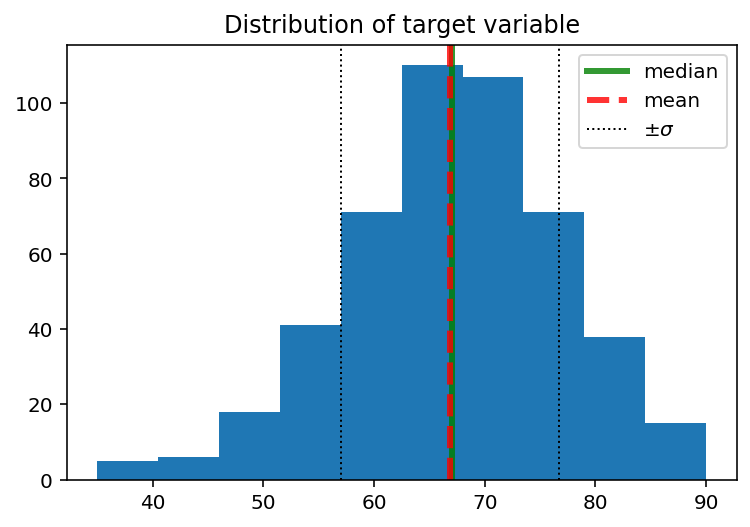

Shapiro-Wilks p-value:  0.004734959
Skewness: -0.3245
Kurtosis:  0.1539


In [5]:
from scipy.stats import kurtosis, shapiro, skew

_df = df_unified[df_unified.oura_summary_date >= ZERO_START]
_df['oura_score'].hist(bins=None, grid=False)
vals = _df['oura_score'].values
plt.axvline(np.median(vals), label='median', c='green', linewidth=3, alpha=0.8)
plt.axvline(np.mean(vals), label='mean', c='red', linestyle='--', linewidth=3, alpha=0.8)
std = vals.std()
plt.axvline(vals.mean() + std, label=r'$\pm \sigma$', c='black', linestyle=':', linewidth=1)
plt.axvline(vals.mean() - std, c='black', linestyle=':', linewidth=1)
plt.title('Distribution of target variable')
plt.legend()
plt.savefig(FIGSDIR/'02_target_distribution.png', dpi=500)
plt.show()

# https://towardsdatascience.com/6-ways-to-test-for-a-normal-distribution-which-one-to-use-9dcf47d8fa93
_, pval = shapiro(vals)
print(f'Shapiro-Wilks p-value: {pval: .9f}')

# https://towardsdatascience.com/skewness-kurtosis-simplified-1338e094fc85
print(f'Skewness: {skew(vals): .4f}')
print(f'Kurtosis: {kurtosis(vals): .4f}')

We seem to have a thin-tailed (positive excess kurtosis), negatively-skewed normal-like distribution.

## Missing Data

In [6]:
# Remove some anomalous columns that were added to datasets recently.
badcols = [
    'oura_ready_score_hrv_balance',
    'sleep_yesterday_ready_score_hrv_balance',
]

df_unified.drop(badcols, axis=1, inplace=True)

First let's quantify how bad the situation is

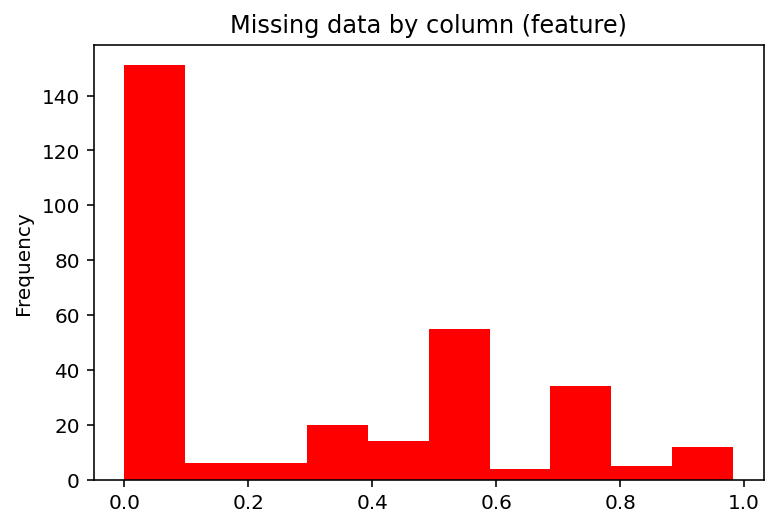

In [7]:
# Analyse by column
df_unified.isnull().mean().plot(
    kind='hist', 
    color='red',
    title='Missing data by column (feature)'
)
plt.savefig(FIGSDIR/'02_missing_data_by_column.eps')
plt.show()

In [9]:
# Sets the start of the study period
init_index = df_unified[df_unified['oura_summary_date'] >= ZERO_START].head(1).index.values[0]
init_index

307

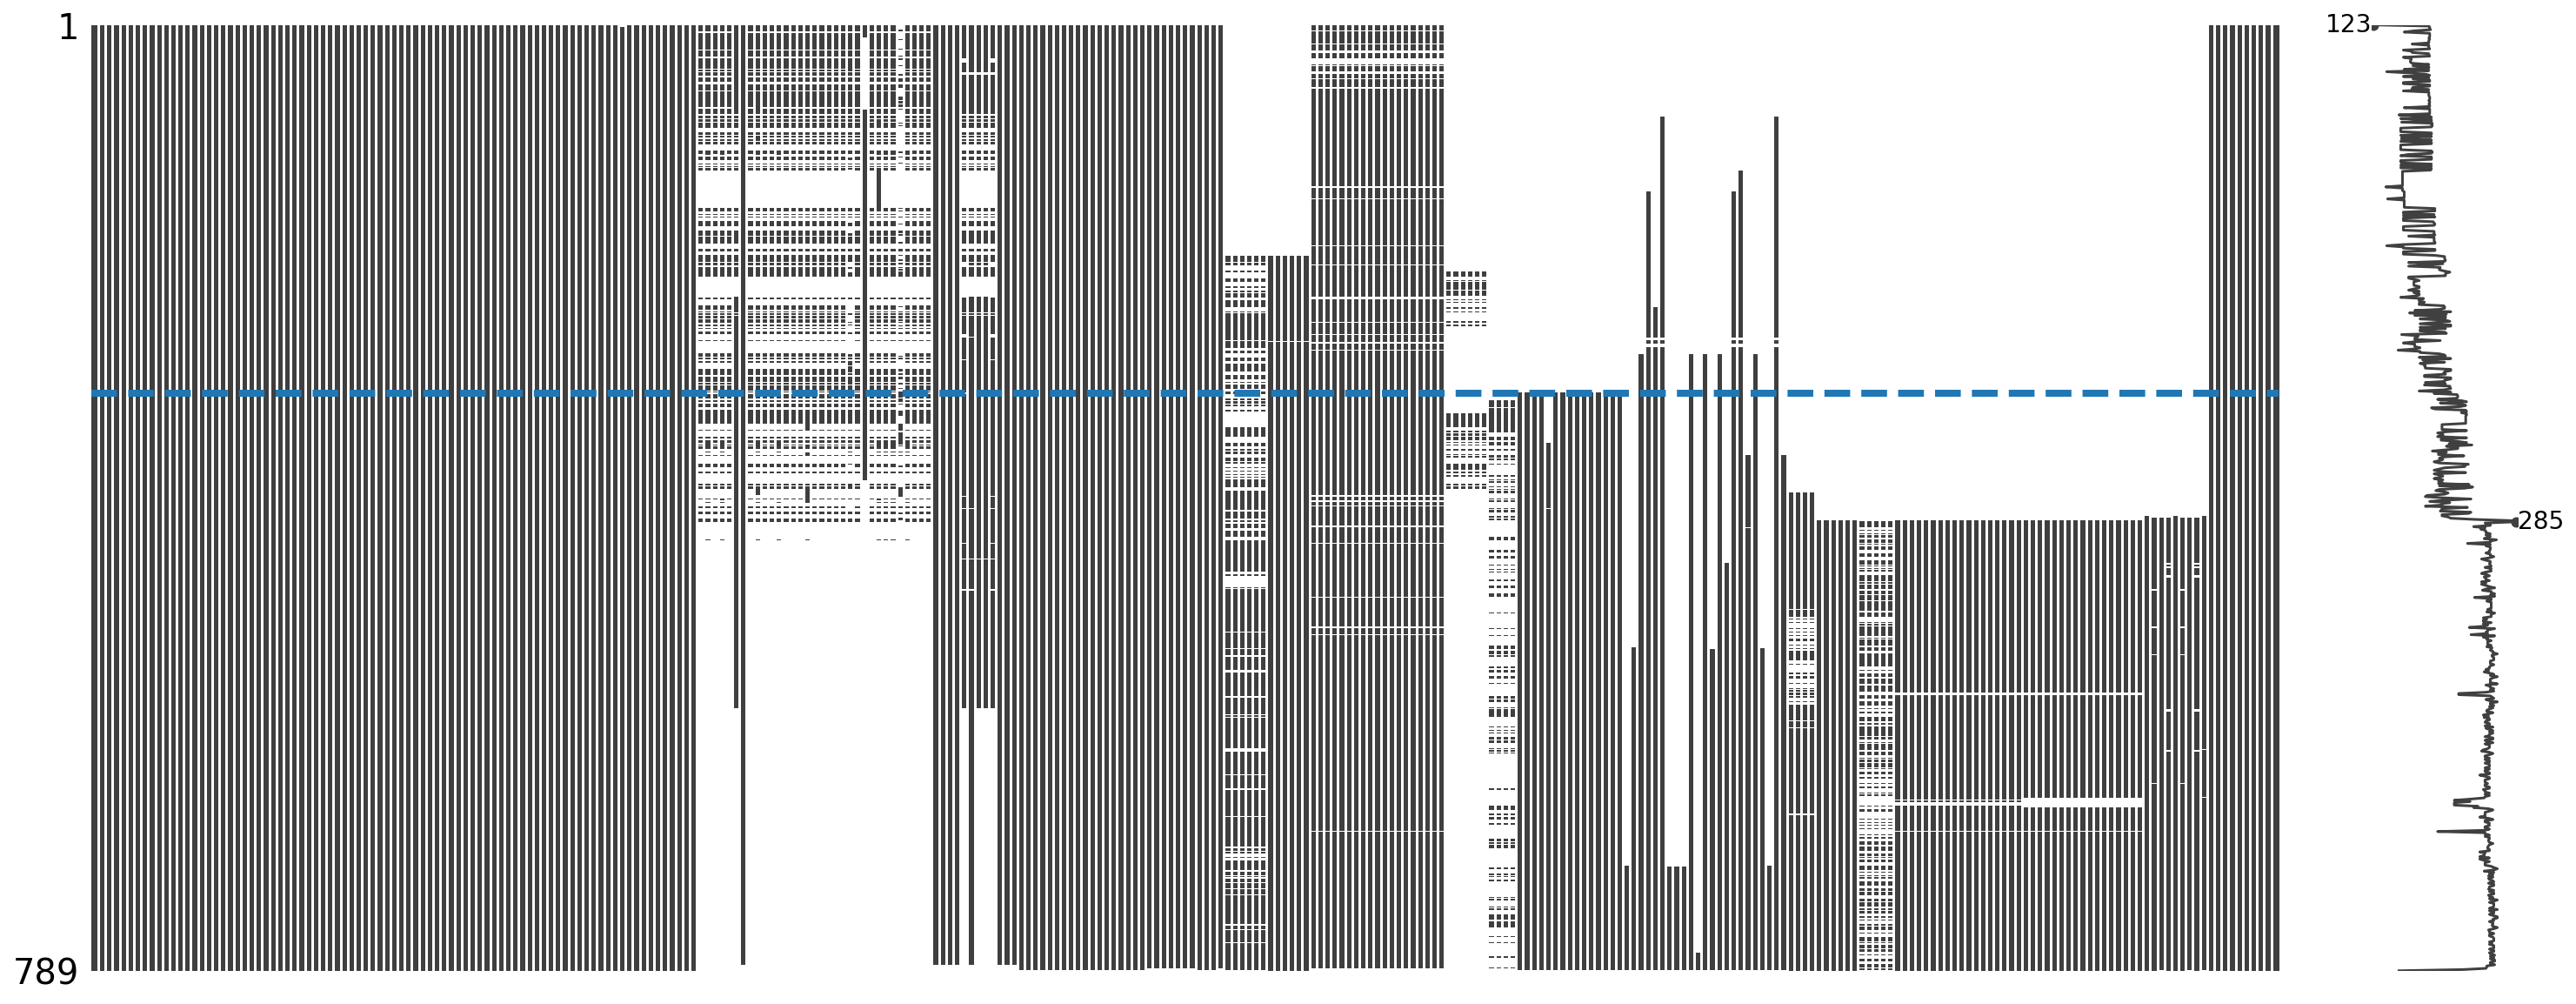

In [10]:
msno.matrix(df_unified)
plt.axhline(init_index, linestyle='--', linewidth=4)
plt.savefig(FIGSDIR/'02_missing_unified_raw.eps')
plt.show()

"The sparkline at right summarizes the general shape of the data completeness and points out the rows with the maximum and minimum nullity in the dataset." — [missingno docs](https://github.com/ResidentMario/missingno)

This is a little tricky to interpret because it's too big for the column names to be displayed. Let's do a little workaround using the prefixes.

In [ ]:
# Extract all the different feature prefixes in our unified view
prefixes = list(set([c.split('_')[0] for c in df_unified.select_dtypes(np.number).columns]))
# Add the different sub-prefixes for AWARE data too
# aware_prefs = list(set(['_'.join(c.split('_')[:2]) for c in df_unified[[col for col in df_unified.columns if col.startswith('aw_')]]]))
aware_prefs = ['aw_calls', 'aw_geohash', 'aw_hr', 'aw_weather', 'aw_loc', 'aw_activ'] # Just doing it manually to simplify
prefixes.extend(aware_prefs)
sorted(prefixes)
prefixes

In [12]:
# Make aggregate columns by collecting the columns with the same top-level prefixes
simplifieds = {}
for prefix in sorted(prefixes):
    cols = [c for c in df_unified.select_dtypes(np.number).columns if c.startswith(prefix)]
    if len(cols) > 2:
        simplifieds[prefix] = df_unified.select_dtypes(np.number)[cols].mean(axis=1, skipna=False)
        # Note: NaNs in any of the columns with that prefix will result in a NaN for the whole column
        
# Create a dataframe of these collected (simplified) columns based on the prefixes
df_simp = pd.DataFrame(simplifieds)
df_simp.head()

aw  aw_activ  aw_calls  aw_geohash  aw_hr  aw_loc  aw_weather  cbd  \
0 NaN       NaN       NaN         NaN    NaN     NaN         NaN  NaN   
1 NaN       NaN       NaN         NaN    NaN     NaN         NaN  NaN   
2 NaN       NaN       NaN         NaN    NaN     NaN         NaN  NaN   
3 NaN       NaN       NaN         NaN    NaN     NaN         NaN  NaN   
4 NaN       NaN       NaN         NaN    NaN     NaN         NaN  NaN   

       city      daily         hk  location  melatonin  mood  nomie  \
0  840903.5        NaN  16.660453       0.2        NaN   NaN    NaN   
1  840903.5  64.030303  24.979473       0.2        NaN   NaN    NaN   
2  840903.5  63.803030  39.349635       0.2        NaN   NaN    NaN   
3  840903.5  63.954545  44.606568       0.2        NaN   NaN    NaN   
4  840903.5  64.393939  41.079953       0.2        NaN   NaN    NaN   

          oura    rescue        sleep  wol  zero  
0          NaN  1.311065          NaN  NaN   NaN  
1  3404.959605  1.462685          NaN  NaN   NaN  
2  4637.781184  0.872901  3404.959605  NaN   NaN  
3  3794.707105  0.430633  4637.781184  NaN   NaN  
4  4241.099211  0.397423  3794.707105  NaN   NaN

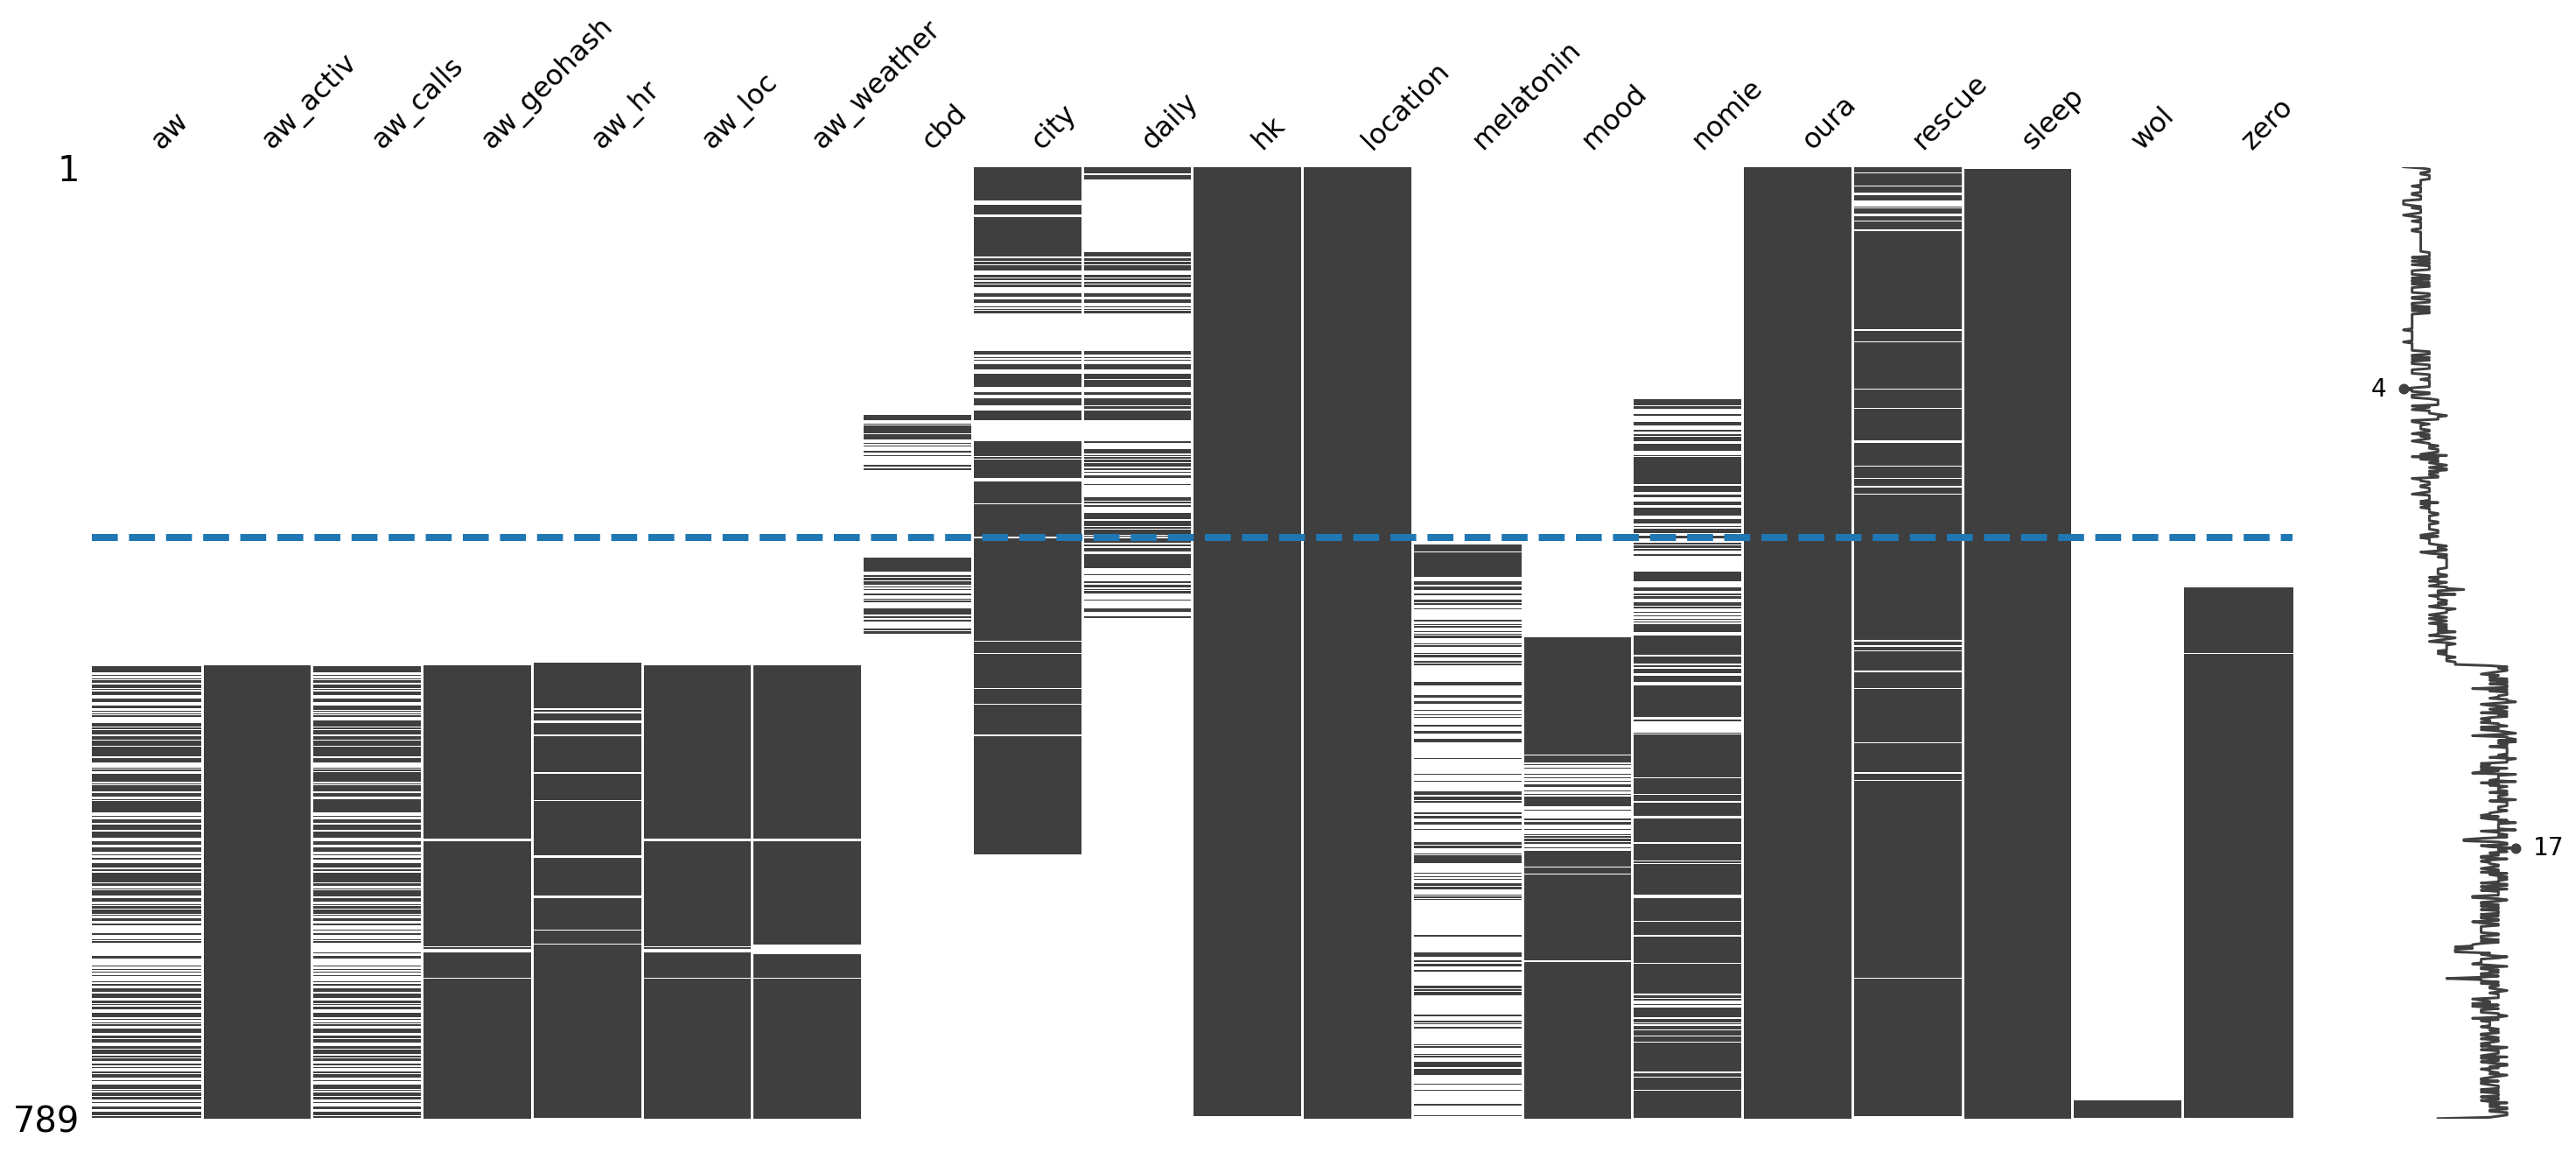

In [13]:
msno.matrix(df_simp)
plt.axhline(init_index, linestyle='--', linewidth=4)
plt.savefig(FIGSDIR/'02_missing_simplified_raw_matrix.png', dpi=500)
plt.show()

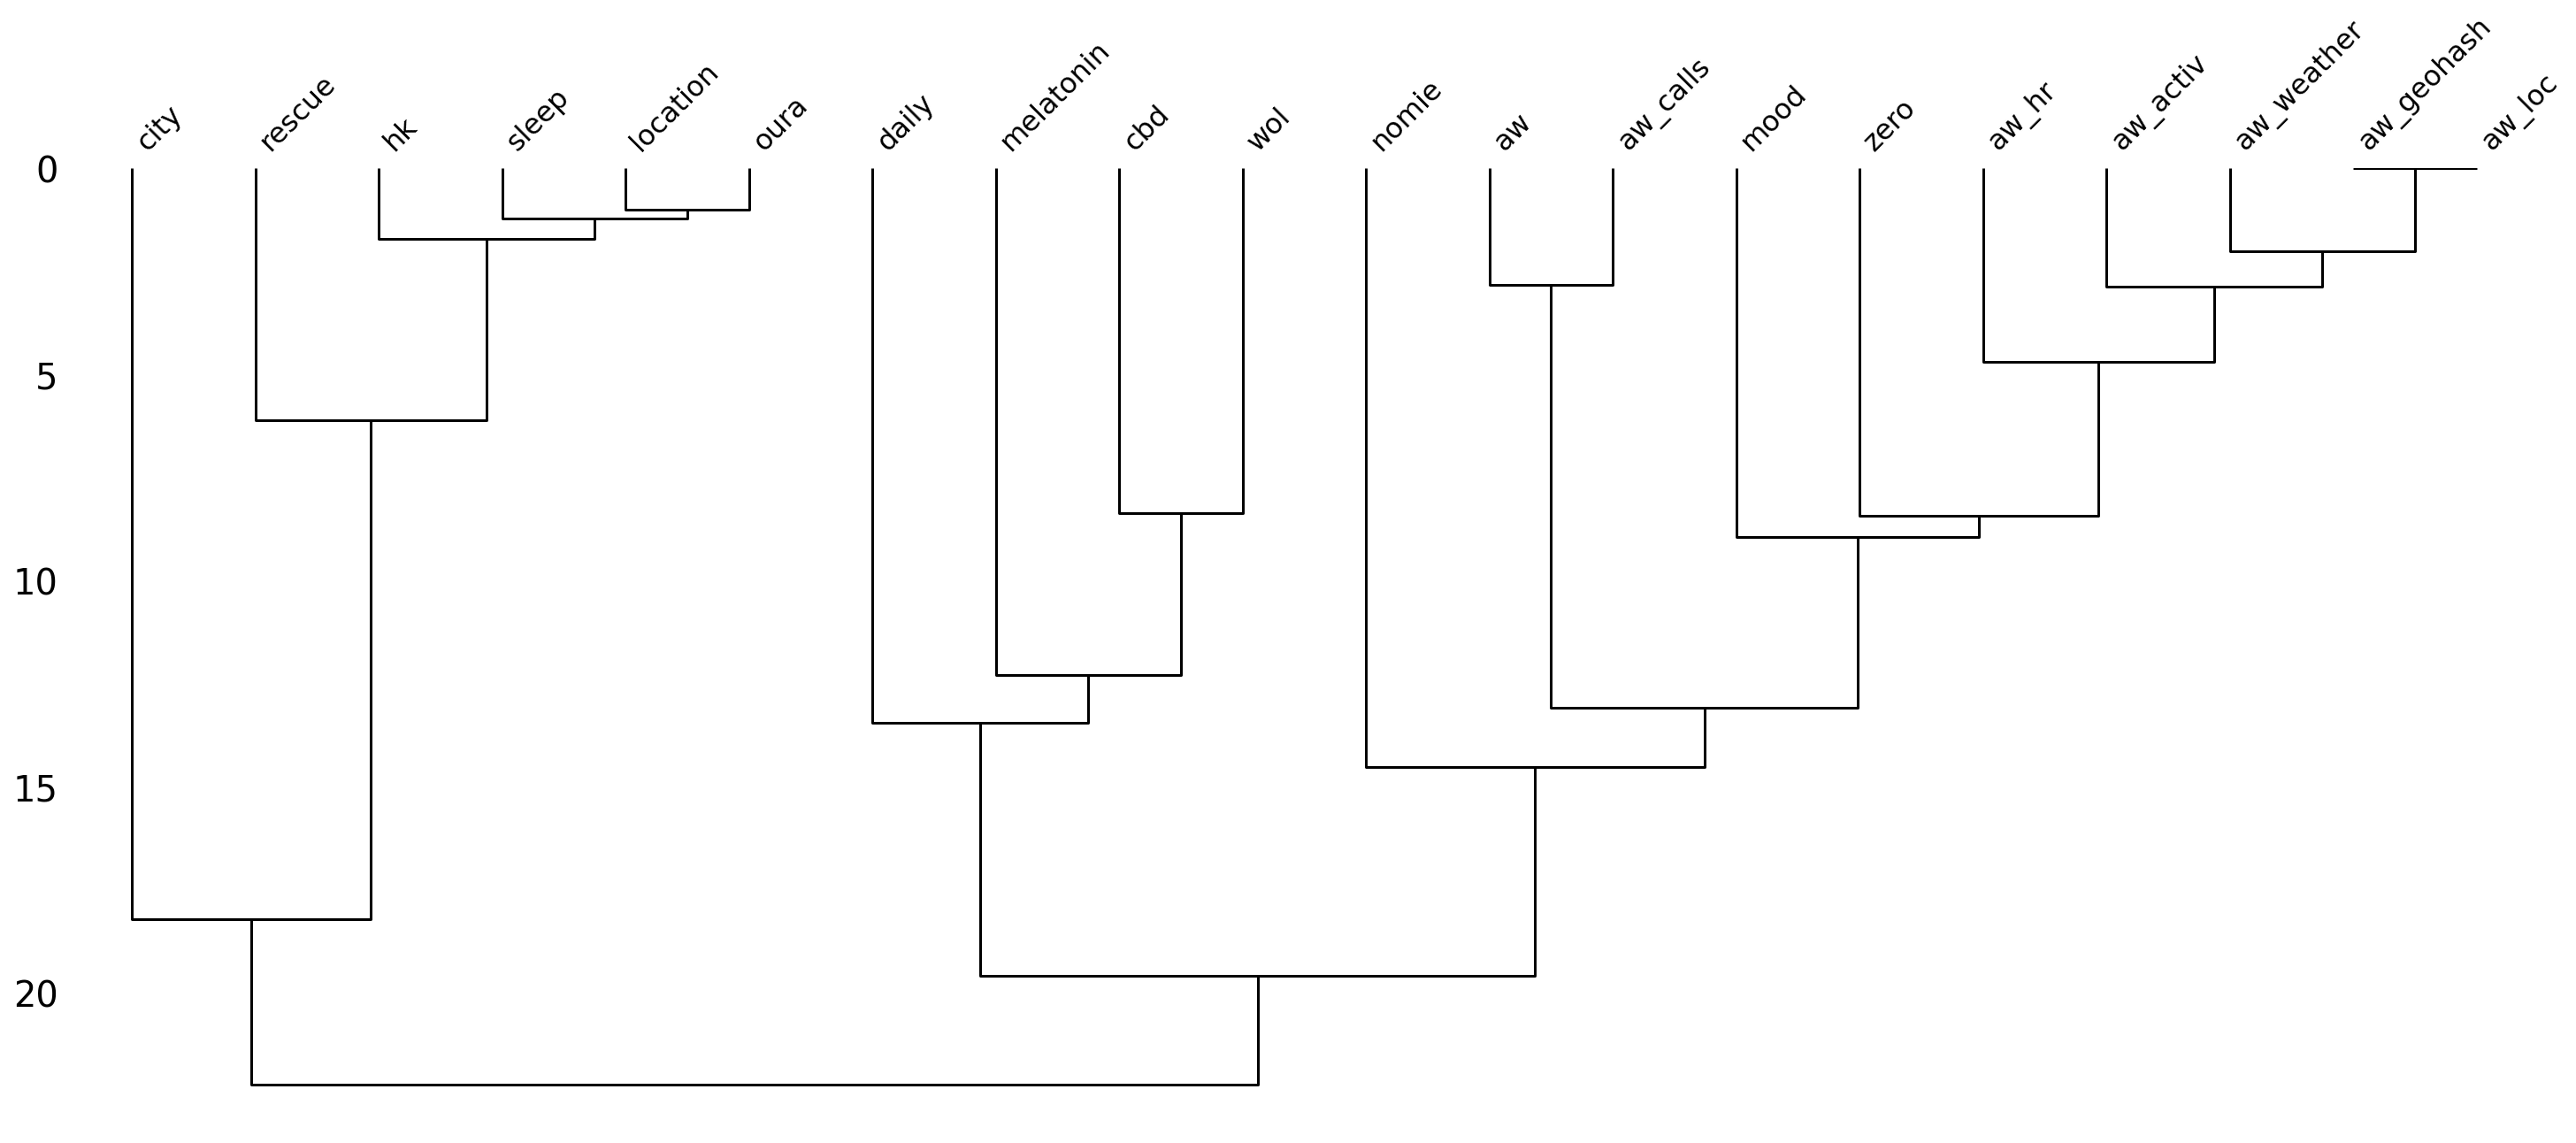

In [15]:
msno.dendrogram(df_simp)
plt.savefig(FIGSDIR/'02_missing_simplified_raw_dendrogram.eps')
plt.show()

In [17]:
def feature_completeness(df, label=None):
    """Plots completeness of rows with respect to included columns (features).
    """
    rows, cols = df.shape
    feat_complete_perc = df.isnull().apply(
        lambda x: 1 - np.mean(x)).sort_values(ascending=False)
    
    X = feat_complete_perc.values
    Y = np.array(np.arange(cols) / float(cols))
    
    return plt.plot(X, Y, label=label)

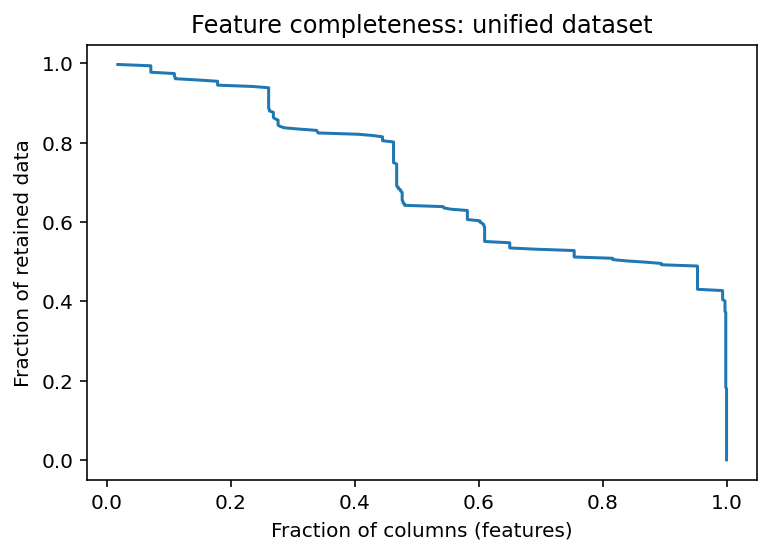

In [18]:
feature_completeness(df_unified)
plt.title('Feature completeness: unified dataset')
plt.xlabel('Fraction of columns (features)')
plt.ylabel('Fraction of retained data')
plt.savefig(FIGSDIR/'02_feature_completeness_unified_raw.eps')
plt.show()

I _think_ the interpretation of the above is: "If I keep 80% of my features, I'll have ~45% complete data. If I keep 90% of my features, I'll have ~40% complete data."

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


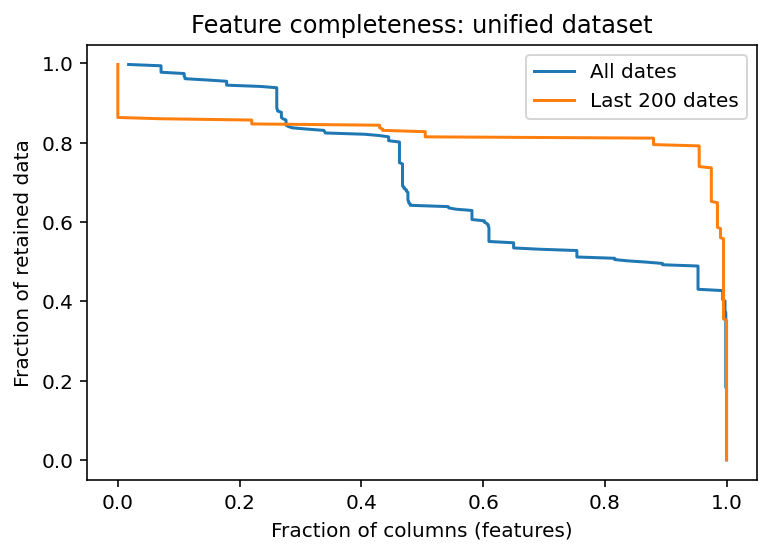

In [19]:
# Does using later parts of the data (last 200 days) result in more completeness?
feature_completeness(df_unified, label="All dates")
feature_completeness(df_unified.tail(200), label="Last 200 dates")
plt.legend()
plt.title('Feature completeness: unified dataset')
plt.xlabel('Fraction of columns (features)')
plt.ylabel('Fraction of retained data')
plt.savefig(FIGSDIR/'02_feature_completeness_unified_by_dates.eps')
plt.show()

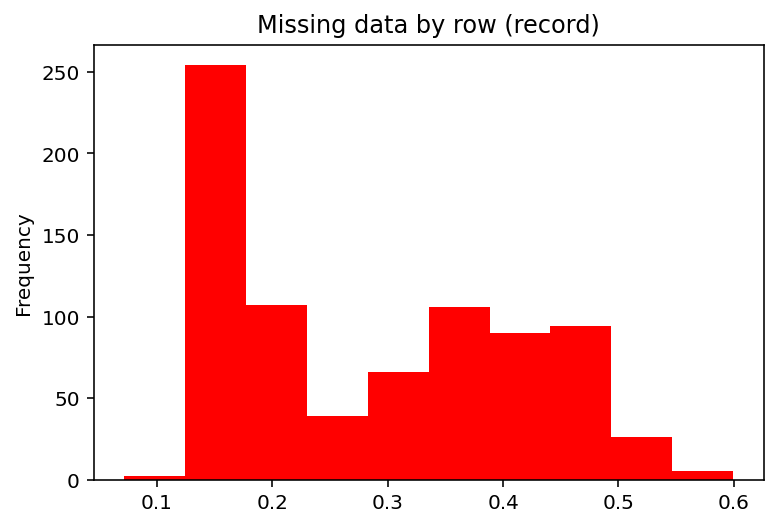

In [20]:
# Analyse by row
df_unified.isnull().mean(axis=1).plot(
    kind='hist', 
    color='red',
    title='Missing data by row (record)'
)
plt.savefig(FIGSDIR/'02_missing_data_by_record.eps')
plt.show()

In [21]:
def record_completeness(df, label=None):
    """ Plots column completeness by number of rows (records) included.
    """
    rows, cols = df.shape
    rec_complete_perc = df.isnull().apply(
        lambda x: 1 - np.mean(x), axis=1).sort_values(ascending=False)
    
    X = rec_complete_perc.values
    Y = np.array(np.arange(rows) / float(rows))
    
    return plt.plot(X, Y, label=label)

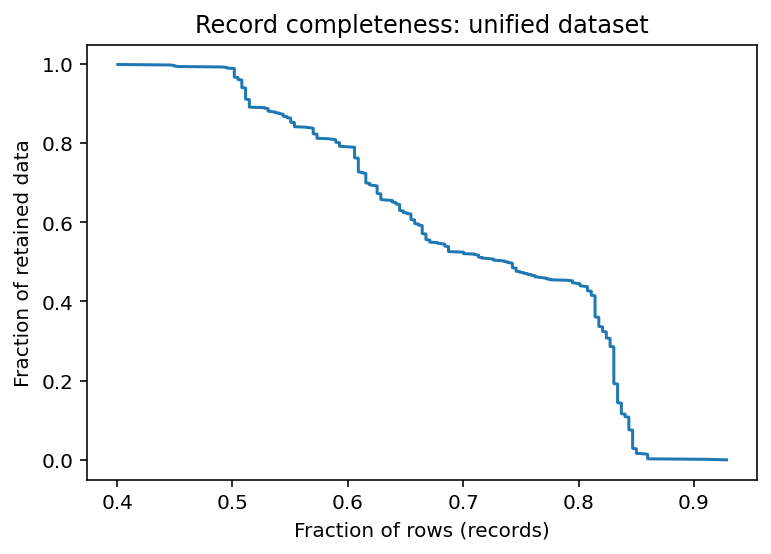

In [22]:
record_completeness(df_unified)
plt.title('Record completeness: unified dataset')
plt.xlabel('Fraction of rows (records)')
plt.ylabel('Fraction of retained data')
plt.savefig(FIGSDIR/'02_record_completeness_unified_raw.eps')
plt.show()

I _think_ the interpretation of the above is: "If I keep 75% of my records, I'll have 30% complete data. If I keep 50% of my records, that rises to 75% complete data."

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


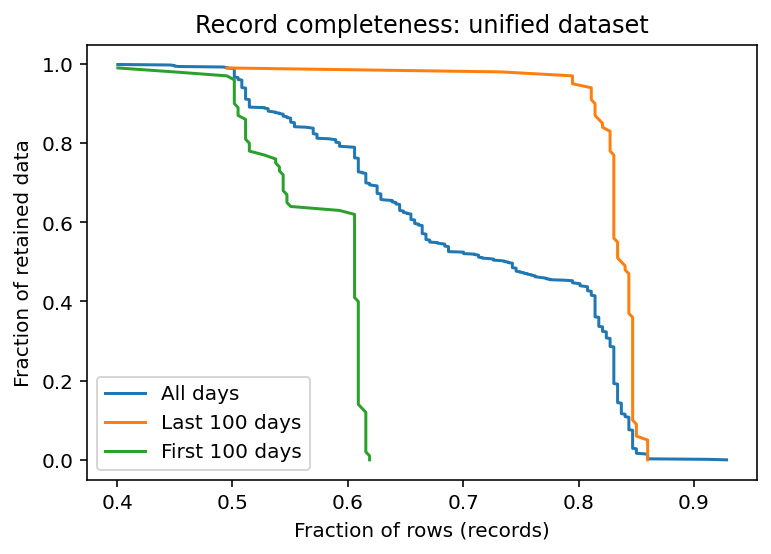

In [23]:
# Look at record completeness for beginning and end of data
record_completeness(df_unified, label="All days")
record_completeness(df_unified.tail(100), label='Last 100 days')
record_completeness(df_unified.head(100), label='First 100 days')

plt.legend()
plt.title('Record completeness: unified dataset')
plt.xlabel('Fraction of rows (records)')
plt.ylabel('Fraction of retained data')
plt.savefig(FIGSDIR/'02_record_completeness_unified_by_dates.eps')
plt.show()

In [24]:
# Analyse the record completeness by column (feature) data type
completes = df_unified.isnull().apply(
        lambda x: 1 - np.mean(x)).reset_index().rename({'index':'field', 0: 'completeness'}, axis=1)
types = df_unified.dtypes.reset_index().rename({'index':'field', 0: 'datatype'}, axis=1)

df_com = types.merge(completes, how='left', on='field').set_index('field')
df_com['datatype'] = df_com['datatype'].apply(lambda x: str(x))
df_com.groupby('datatype').mean().sort_values(by='completeness')

completeness
datatype              
object        0.665811
float64       0.674763
int64         1.000000

In [26]:
# Convert some stragler categoricals to datetime
df_unified['daily_date'] = pd.to_datetime(df_unified['daily_date'])
df_unified['hk_day'] = pd.to_datetime(df_unified['hk_day'])

(749, 307)
(595, 307)
(481, 307)
(374, 307)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


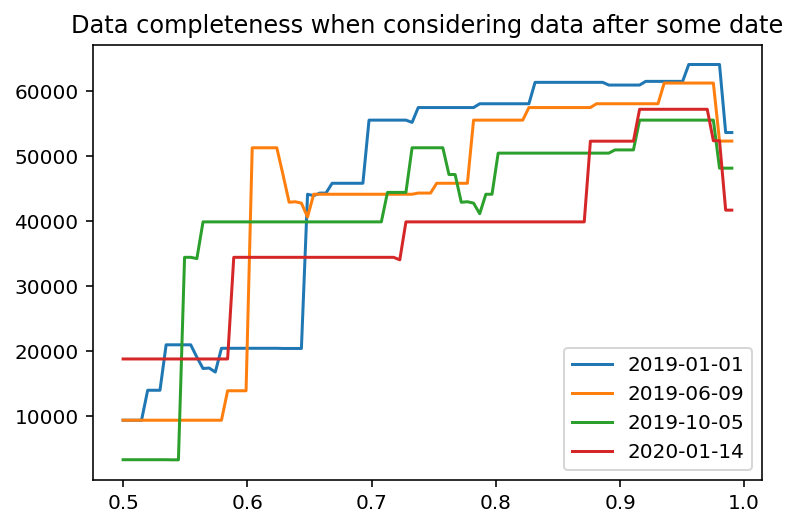

In [28]:
def eval_data_completeness(data, rec_thresh=0.5, resolution=100):
    data = data[[c for c in data.columns if 'oura' not in c]]
    data = data.select_dtypes(include=np.number)
    data = data.dropna(axis=0, thresh=int(rec_thresh*data.shape[1]))
    
    x = []
    y = []
    for thresh in np.linspace(0.5, 0.99, resolution):
        x.append(thresh)
        shape = data.dropna(axis=1, thresh=int(thresh*data.shape[0])).dropna().shape
        y.append(shape[0]*shape[1])
        
    return x,y 

fig, ax = plt.subplots(1, 1)
for i, date in enumerate(['2019-01-01', NOMIE_START, ZERO_START, AWARE_START]):
    test_data = df_unified[df_unified['oura_summary_date'] > date]
    print(test_data.shape)
    x, y = eval_data_completeness(test_data)
    ax.plot(x, y, label=date)
plt.legend()
plt.title("Data completeness when considering data after some date")
plt.savefig(FIGSDIR/'02_data_completeness_by_date.eps')
plt.show()

In [29]:
# Drop rows and columns that fall below the thresholds for completeness of data

REC_THRESH = 0.5
FEAT_THRESH = 0.88
start_date = ZERO_START

data = df_unified[df_unified['oura_summary_date'] > start_date].select_dtypes(include=np.number)
print("Original:", data.shape)

# data = data.dropna(axis=0, thresh=int(REC_THRESH*data.shape[1]))
data = data.dropna(axis=1, thresh=int(FEAT_THRESH*data.shape[0]))
print("Pruned:", data.shape)

Original: (481, 267)
Pruned: (481, 160)


In [30]:
# Drop remaining NaN rows
data = data.dropna()
data.shape

(413, 160)

In [31]:
# Import some scikit-learn tools for basic regression and feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split

In [32]:
# Set up a matrix X of features and a vector y of labels (sleep score)
TARGET = 'oura_score'

# Hide all the columns with other Oura (sleep) data to prevent data leaks
hidden = data[[c for c in data.columns if 'oura' in c]]
print(hidden.columns) # Printed for inspection
X = data[[c for c in data.columns if 'oura' not in c]]
y = data[TARGET]

print(X.shape, y.shape)

Index(['oura_awake', 'oura_bedtime_end_delta', 'oura_bedtime_start_delta',
       'oura_breath_average', 'oura_deep', 'oura_duration', 'oura_efficiency',
       'oura_hr_average', 'oura_hr_lowest', 'oura_light',
       'oura_midpoint_at_delta', 'oura_midpoint_time', 'oura_onset_latency',
       'oura_period_id', 'oura_rem', 'oura_restless', 'oura_rmssd',
       'oura_score', 'oura_score_alignment', 'oura_score_deep',
       'oura_score_disturbances', 'oura_score_efficiency',
       'oura_score_latency', 'oura_score_rem', 'oura_score_total',
       'oura_temperature_delta', 'oura_temperature_deviation',
       'oura_temperature_trend_deviati', 'oura_timezone', 'oura_total',
       'oura_ready_score', 'oura_ready_score_activity_bala',
       'oura_ready_score_previous_day', 'oura_ready_score_previous_nigh',
       'oura_ready_score_recovery_inde', 'oura_ready_score_resting_hr',
       'oura_ready_score_sleep_balance', 'oura_ready_score_temperature'],
      dtype='object')
(413, 122) (413

In [33]:
# Perform k-fold cross validation on all the (hidden) Oura/sleep features 

from sklearn.preprocessing import Normalizer, StandardScaler

norm = Normalizer()

target_results = {}

for col in hidden.columns:
    results = {'r2':[], 'rmse': []}
    kf = KFold(n_splits=5, shuffle=True)
    feat_cols = [c for c in data.columns if 'oura' not in c]

    for train_index, test_index in kf.split(X):
        train, test = pd.DataFrame(norm.fit_transform(data.values[train_index]), columns=data.columns), pd.DataFrame(norm.fit_transform(data.values[test_index]), columns=data.columns)
        X_train, X_test = norm.fit_transform(train[feat_cols]), norm.fit_transform(test[feat_cols])
        y_train, y_test = train[col], test[col]
        
        mod = LinearRegression().fit(X_train, y_train)
        preds = mod.predict(X_test)
        results['r2'].append(r2_score(y_test, preds))
        results['rmse'].append(mean_squared_error(y_test, preds, squared=False))

    target_results[col] = {k: np.nanmean(v) for k,v in results.items()}

df_targres = pd.DataFrame(target_results).T

df_targres.sort_values('rmse').head(20)

r2      rmse
oura_temperature_deviation      -9308.164999  0.000095
oura_temperature_trend_deviati -35145.061213  0.000140
oura_score_total                   -0.407791  0.000209
oura_temperature_delta         -57592.485735  0.000242
oura_period_id                  -1912.858998  0.000314
oura_score_latency                 -3.959260  0.000344
oura_ready_score_activity_bala    -25.972136  0.000650
oura_ready_score_temperature      -49.524137  0.000697
oura_breath_average             -9977.705633  0.000789
oura_score_efficiency            -116.410873  0.001081
oura_efficiency                  -704.510657  0.001460
oura_ready_score                -1392.042085  0.002186
oura_rmssd                      -1779.222462  0.003461
oura_hr_lowest                  -9692.507834  0.004286
oura_timezone                    -666.113038  0.004531
oura_restless                  -34762.931027  0.005786
oura_ready_score_previous_day   -2152.501321  0.006361
oura_ready_score_previous_nigh  -3532.978100  0.007700
oura_ready_score_sleep_balance  -9569.563361  0.008149
oura_score_disturbances        -13705.640222  0.008347

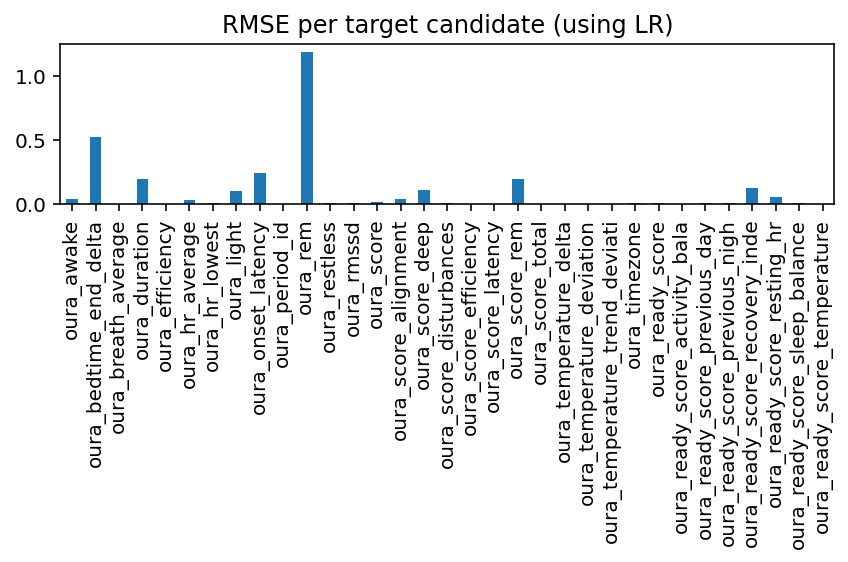

In [34]:
# Inspect which features have the lowest prediction error
df_targres[df_targres.rmse < 2]['rmse'].plot.bar()
plt.title('RMSE per target candidate (using LR)')
plt.tight_layout()
plt.savefig(FIGSDIR/'02_candidate_feature_rmse.eps')
plt.show()

In [35]:
# Drop all columns the might leak data
drop_cols = list(data.columns)
drop_cols = [c for c in drop_cols if 'oura' in c and 'day' not in c]
print('dropping:', drop_cols)
X = data.drop(drop_cols, axis=1)
y = data['oura_score']
df_export = X.copy()
df_export['target'] = y

dropping: ['oura_awake', 'oura_bedtime_end_delta', 'oura_bedtime_start_delta', 'oura_breath_average', 'oura_deep', 'oura_duration', 'oura_efficiency', 'oura_hr_average', 'oura_hr_lowest', 'oura_light', 'oura_midpoint_at_delta', 'oura_midpoint_time', 'oura_onset_latency', 'oura_period_id', 'oura_rem', 'oura_restless', 'oura_rmssd', 'oura_score', 'oura_score_alignment', 'oura_score_deep', 'oura_score_disturbances', 'oura_score_efficiency', 'oura_score_latency', 'oura_score_rem', 'oura_score_total', 'oura_temperature_delta', 'oura_temperature_deviation', 'oura_temperature_trend_deviati', 'oura_timezone', 'oura_total', 'oura_ready_score', 'oura_ready_score_activity_bala', 'oura_ready_score_previous_nigh', 'oura_ready_score_recovery_inde', 'oura_ready_score_resting_hr', 'oura_ready_score_sleep_balance', 'oura_ready_score_temperature']


### Autocorrelation

In [39]:
# Complete the autocorrelation of every feature for lag between 1 and 15
acorrs = {}
for col in data.columns:
    acorrs[col] = [data[col].autocorr(lag=i) for i in range(1, 15)]
acorrs = pd.DataFrame.from_dict(acorrs)
acorrs.shape

(14, 160)

In [ ]:
acorrs.max().sort_values(ascending=False).head(30)

In [ ]:
# Inspect the autocorrelations via plots to pick up on any patterns

from statsmodels.graphics.tsaplots import plot_acf

for col in data.select_dtypes(include=np.number).columns:
    plot_acf(data[col], title=f"Autocorrelation of '{col}' (N={data[col].dropna().shape[0]})")
    plt.savefig(FIGSDIR/f'autocorrelation/autocorr_{col}.png', dpi=500)
    plt.show()

Okay, the autocorrelations are a _little_ informative, but not as much as I expected. They also seem quite dependent on data cleanliness.

### Stationarity

Let's use an Augmented Dick-Fuller test to see which of the current features are stationary, as per [this guide](https://machinelearningmastery.com/time-series-data-stationary-python/).


In [42]:
from statsmodels.tsa.stattools import adfuller

adfullers = {'feature': [], 'p-val': []}
for col in data.select_dtypes(np.number).columns:
    vals = data[col].values
    result = adfuller(vals) #  statistic, p-val, [critical values]
    adfullers['feature'].append(col)
    adfullers['p-val'].append(result[1])
    
df_stationary = pd.DataFrame(adfullers)
df_stationary['stationary'] = df_stationary['p-val'].apply(lambda x: 1 if x <= 0.05 else 0)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:889: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


In [43]:
# Oura (sleep) data (what really needs to be stationary for good modelling)
df_stationary[df_stationary.feature.isin([c for c in df_stationary.feature if 'oura' in c])]

feature         p-val  stationary
0                       oura_awake  0.000000e+00           1
1           oura_bedtime_end_delta  8.643386e-10           1
2         oura_bedtime_start_delta  4.779983e-05           1
3              oura_breath_average  4.572835e-02           1
4                        oura_deep  4.726680e-10           1
5                    oura_duration  6.660055e-19           1
6                  oura_efficiency  2.218169e-03           1
7                  oura_hr_average  3.617632e-05           1
8                   oura_hr_lowest  4.734355e-05           1
9                       oura_light  4.443488e-02           1
10          oura_midpoint_at_delta  1.088552e-04           1
11              oura_midpoint_time  0.000000e+00           1
12              oura_onset_latency  0.000000e+00           1
13                  oura_period_id  1.660403e-05           1
14                        oura_rem  6.751268e-07           1
15                   oura_restless  2.671703e-06           1
16                      oura_rmssd  6.403696e-03           1
17                      oura_score  9.507503e-03           1
18            oura_score_alignment  2.883705e-04           1
19                 oura_score_deep  0.000000e+00           1
20         oura_score_disturbances  5.858360e-04           1
21           oura_score_efficiency  2.496711e-03           1
22              oura_score_latency  0.000000e+00           1
23                  oura_score_rem  1.630340e-03           1
24                oura_score_total  8.717684e-17           1
25          oura_temperature_delta  0.000000e+00           1
26      oura_temperature_deviation  0.000000e+00           1
27  oura_temperature_trend_deviati  9.543702e-04           1
28                   oura_timezone  2.723492e-01           0
29                      oura_total  3.802498e-17           1
30                oura_ready_score  1.428477e-02           1
31  oura_ready_score_activity_bala  4.443683e-03           1
32   oura_ready_score_previous_day  1.108044e-01           0
33  oura_ready_score_previous_nigh  2.291816e-02           1
34  oura_ready_score_recovery_inde  0.000000e+00           1
35     oura_ready_score_resting_hr  6.973751e-08           1
36  oura_ready_score_sleep_balance  1.547614e-03           1
37    oura_ready_score_temperature  0.000000e+00           1

In [ ]:
# The least stationary featueres
df_stationary[df_stationary.stationary == 0].sort_values('p-val', ascending=False).round(5).reset_index(drop=True)

In [45]:
# The most stationary features
df_stationary.sort_values('p-val', ascending=True).head(50)

feature         p-val  stationary
0                                   oura_awake  0.000000e+00           1
25                      oura_temperature_delta  0.000000e+00           1
26                  oura_temperature_deviation  0.000000e+00           1
34              oura_ready_score_recovery_inde  0.000000e+00           1
37                oura_ready_score_temperature  0.000000e+00           1
43                    sleep_yesterday_duration  0.000000e+00           1
49               sleep_yesterday_midpoint_time  0.000000e+00           1
50               sleep_yesterday_onset_latency  0.000000e+00           1
60               sleep_yesterday_score_latency  0.000000e+00           1
75     sleep_yesterday_ready_score_temperature  0.000000e+00           1
88                                   hk_act_6h  0.000000e+00           1
89                                   hk_act_7h  0.000000e+00           1
93                                  hk_act_11h  0.000000e+00           1
98                                  hk_act_16h  0.000000e+00           1
104                                 hk_act_22h  0.000000e+00           1
124                            rescue_shopping  0.000000e+00           1
22                          oura_score_latency  0.000000e+00           1
19                             oura_score_deep  0.000000e+00           1
72   sleep_yesterday_ready_score_recovery_inde  0.000000e+00           1
12                          oura_onset_latency  0.000000e+00           1
11                          oura_midpoint_time  0.000000e+00           1
86                                   hk_act_4h  2.240788e-30           1
103                                 hk_act_21h  2.488158e-30           1
63           sleep_yesterday_temperature_delta  6.407353e-29           1
64       sleep_yesterday_temperature_deviation  6.407353e-29           1
97                                  hk_act_15h  1.894571e-28           1
94                                  hk_act_12h  5.649359e-25           1
153                             location_Other  6.073301e-22           1
5                                oura_duration  6.660055e-19           1
95                                  hk_act_13h  1.775355e-17           1
67                       sleep_yesterday_total  2.161751e-17           1
29                                  oura_total  3.802498e-17           1
62                 sleep_yesterday_score_total  4.771797e-17           1
24                            oura_score_total  8.717684e-17           1
77                               daily_weekday  8.356463e-16           1
90                                   hk_act_8h  3.266173e-15           1
87                                   hk_act_5h  9.003551e-15           1
147                              wol_read_book  1.745573e-14           1
42                        sleep_yesterday_deep  2.433266e-13           1
96                                  hk_act_14h  1.774469e-12           1
4                                    oura_deep  4.726680e-10           1
1                       oura_bedtime_end_delta  8.643386e-10           1
144                             wol_no_alcohol  2.152490e-09           1
39           sleep_yesterday_bedtime_end_delta  2.713190e-09           1
85                                   hk_act_3h  9.100435e-09           1
131                    rescue_very_distracting  1.905128e-08           1
35                 oura_ready_score_resting_hr  6.973751e-08           1
146                       wol_pescatarian_diet  1.283640e-07           1
61                   sleep_yesterday_score_rem  1.963179e-07           1
117                              rescue_design  3.424242e-07           1

In [75]:
df_stationary[df_stationary.feature == TARGET]

feature     p-val  stationary
17  oura_score  0.009508           1

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


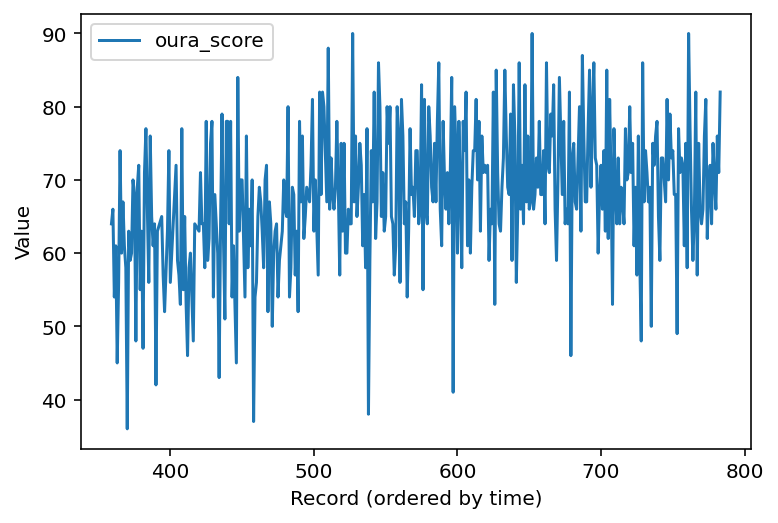

In [47]:
# Our primary target feature (which is stationary according to ADF test)
data[['oura_score']].plot()
plt.xlabel('Record (ordered by time)')
plt.ylabel('Value')
plt.savefig(FIGSDIR/f'02_stationarity_target.eps')
plt.show()

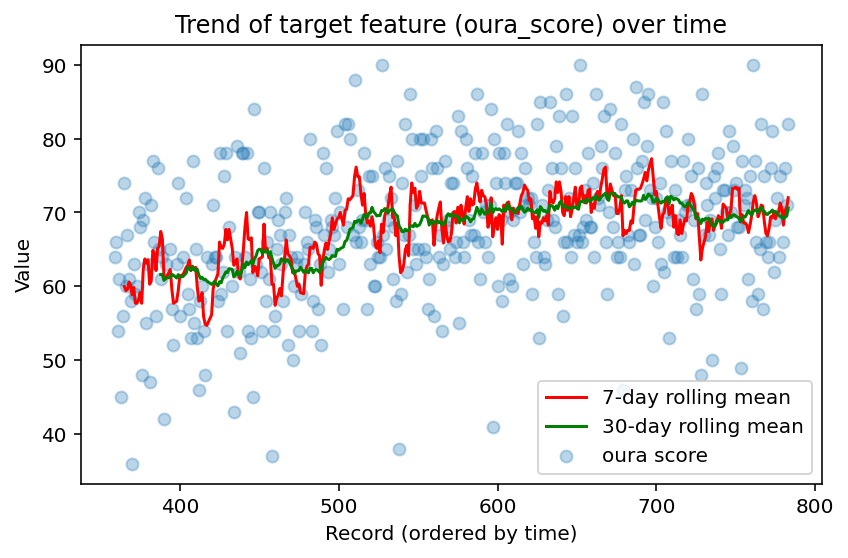

In [48]:
# Analyse rolling averages of target feature (oura score)
rolling_mean_7 = data['oura_score'].rolling(7).mean()
rolling_mean_30 = data['oura_score'].rolling(30).mean()

plt.scatter(data.index, data.oura_score, label='oura score', alpha=0.3)
plt.plot(rolling_mean_7, label="7-day rolling mean", c='red')
plt.plot(rolling_mean_30, label="30-day rolling mean", c='green')
plt.legend()
plt.title('Trend of target feature (oura_score) over time')
plt.xlabel('Record (ordered by time)')
plt.ylabel('Value')
plt.savefig(FIGSDIR/'02_trend_target_rolling.png', dpi=500)
plt.tight_layout()
plt.show()

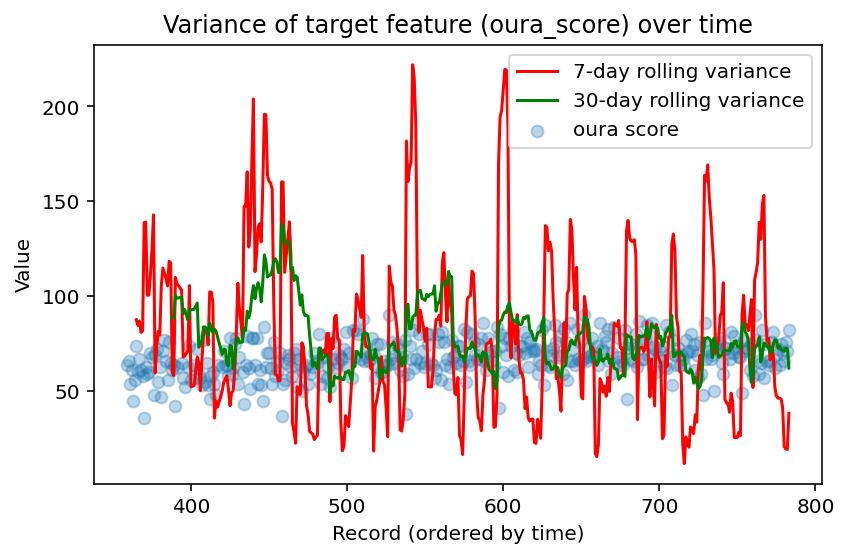

In [49]:
# Analyse rolling averages of variance of target feature (oura score)

rolling_var_7 = np.square(data['oura_score'].rolling(7).std())
rolling_var_30 = np.square(data['oura_score'].rolling(30).std())

plt.scatter(data.index, data.oura_score, label='oura score', alpha=0.3)
plt.plot(rolling_var_7, label="7-day rolling variance", c='red')
plt.plot(rolling_var_30, label="30-day rolling variance", c='green')
plt.legend()
plt.title('Variance of target feature (oura_score) over time')
plt.xlabel('Record (ordered by time)')
plt.ylabel('Value')
plt.savefig(FIGSDIR/'02_trend_target_rolling_variance.png', dpi=500)
plt.tight_layout()
plt.show()

In [50]:
data.shape

(413, 160)

We also need to check if the data was stationary before we dropped much of it. The NaNs (which caused us to drop) break the augmented Dick Fuller test, but we can just look at the Oura data — this is what we really care about being stationary and it's got no NaNs.

In [51]:
adfullers_oura = {'feature': [], 'p-val': []}
for col in [c for c in df_unified.select_dtypes(np.number).columns if 'oura' in c]:
    vals = df_unified[col].dropna().values
    result = adfuller(vals) #  statistic, p-val, [critical values]
    adfullers_oura['feature'].append(col)
    adfullers_oura['p-val'].append(result[1])
    
df_stat_oura = pd.DataFrame(adfullers_oura)
df_stat_oura['stationary'] = df_stat_oura['p-val'].apply(lambda x: 1 if x <= 0.05 else 0)
df_stat_oura.sort_values('p-val', ascending=True)

feature         p-val  stationary
37    oura_ready_score_temperature  0.000000e+00           1
34  oura_ready_score_recovery_inde  0.000000e+00           1
26      oura_temperature_deviation  0.000000e+00           1
25          oura_temperature_delta  0.000000e+00           1
11              oura_midpoint_time  0.000000e+00           1
13                  oura_period_id  6.313243e-11           1
19                 oura_score_deep  1.775033e-09           1
4                        oura_deep  1.063483e-07           1
36  oura_ready_score_sleep_balance  2.377742e-07           1
35     oura_ready_score_resting_hr  1.030407e-06           1
12              oura_onset_latency  1.878667e-06           1
9                       oura_light  2.023664e-06           1
27  oura_temperature_trend_deviati  2.584168e-06           1
22              oura_score_latency  5.322448e-06           1
0                       oura_awake  7.525565e-06           1
5                    oura_duration  9.931143e-05           1
8                   oura_hr_lowest  1.930992e-03           1
3              oura_breath_average  2.185403e-03           1
15                   oura_restless  2.546638e-03           1
31  oura_ready_score_activity_bala  2.829570e-03           1
1           oura_bedtime_end_delta  5.138323e-03           1
29                      oura_total  8.564950e-03           1
18            oura_score_alignment  1.135275e-02           1
24                oura_score_total  1.263529e-02           1
7                  oura_hr_average  1.674981e-02           1
2         oura_bedtime_start_delta  1.710809e-02           1
10          oura_midpoint_at_delta  1.884346e-02           1
20         oura_score_disturbances  3.334428e-02           1
16                      oura_rmssd  3.384844e-02           1
14                        oura_rem  5.142159e-02           0
30                oura_ready_score  8.251106e-02           0
17                      oura_score  8.490156e-02           0
23                  oura_score_rem  1.187948e-01           0
32   oura_ready_score_previous_day  1.831784e-01           0
6                  oura_efficiency  1.935364e-01           0
28                   oura_timezone  2.035428e-01           0
33  oura_ready_score_previous_nigh  2.109612e-01           0
21           oura_score_efficiency  2.197788e-01           0

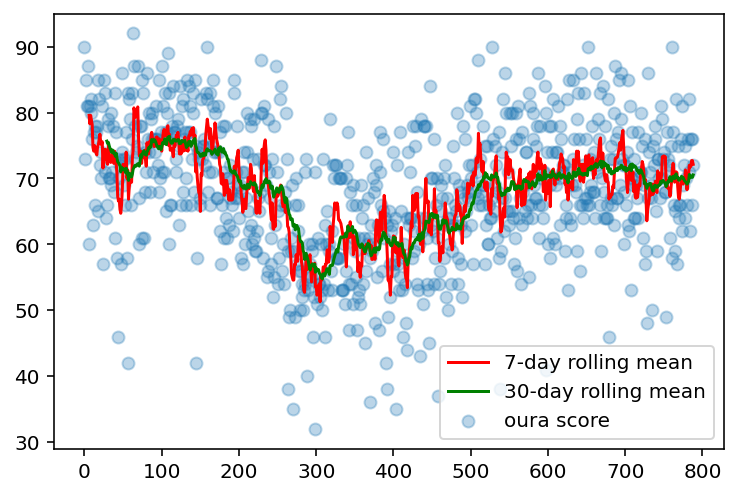

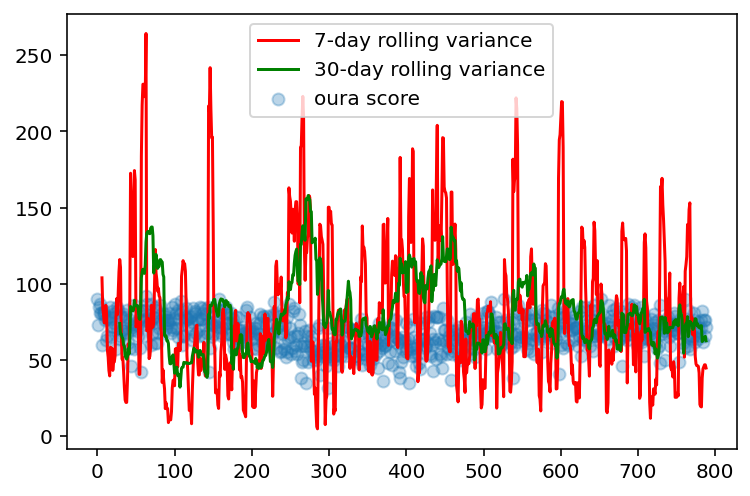

In [52]:
rolling_mean_7 = df_unified['oura_score'].rolling(7).mean()
rolling_mean_30 = df_unified['oura_score'].rolling(30).mean()

plt.scatter(df_unified.index, df_unified.oura_score, label='oura score', alpha=0.3)
plt.plot(rolling_mean_7, label="7-day rolling mean", c='red')
plt.plot(rolling_mean_30, label="30-day rolling mean", c='green')
plt.legend()
plt.show()

rolling_var_7 = np.square(df_unified['oura_score'].rolling(7).std())
rolling_var_30 = np.square(df_unified['oura_score'].rolling(30).std())

plt.scatter(df_unified.index, df_unified.oura_score, label='oura score', alpha=0.3)
plt.plot(rolling_var_7, label="7-day rolling variance", c='red')
plt.plot(rolling_var_30, label="30-day rolling variance", c='green')
plt.legend()
plt.show()

## Extended correlation analysis

In [53]:
print(df_unified.shape)
print(df_unified.dropna().shape)

# Only analyse the portion of the data that has fewer missing values.
_df = df_unified[df_unified.oura_summary_date >= AWARE_START]
print(_df.shape)
print(_df.dropna().shape)

(789, 307)
(0, 307)
(375, 307)
(0, 307)


In [54]:
NANTHRESH = 0.1

okaycols = []
for c in _df.columns:
    if _df[c].isna().mean() <= NANTHRESH:
        okaycols.append(c)
        
print(len(okaycols))

237


In [55]:
# Let's do correlation analysis
corr_data = _df[okaycols]
corr = corr_data.corr()

In [56]:
corr.shape

(207, 207)

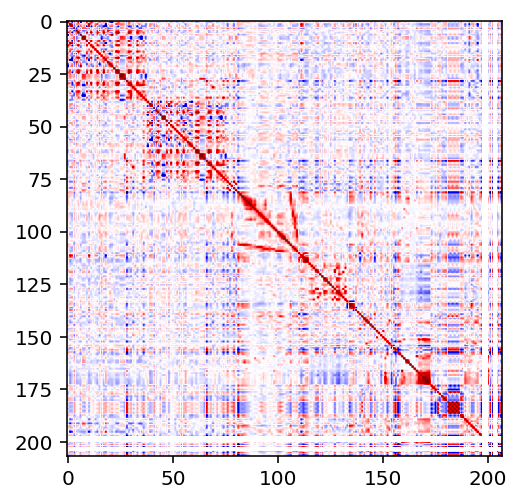

In [58]:
plt.imshow(corr, cmap='seismic')
plt.savefig(FIGSDIR/'02_correlation_matrix_full.png', dpi=400)

In [59]:
to_target = corr['oura_score']
sleepcols = [c for c in corr.columns if 'sleep' in c or 'oura' in c]
othercols = [c for c in corr.columns if c not in sleepcols]
# Redact some locations for privacy reasons
othercols = [c for c in othercols if 'location_' not in c and 'loc_geohash_' not in c]

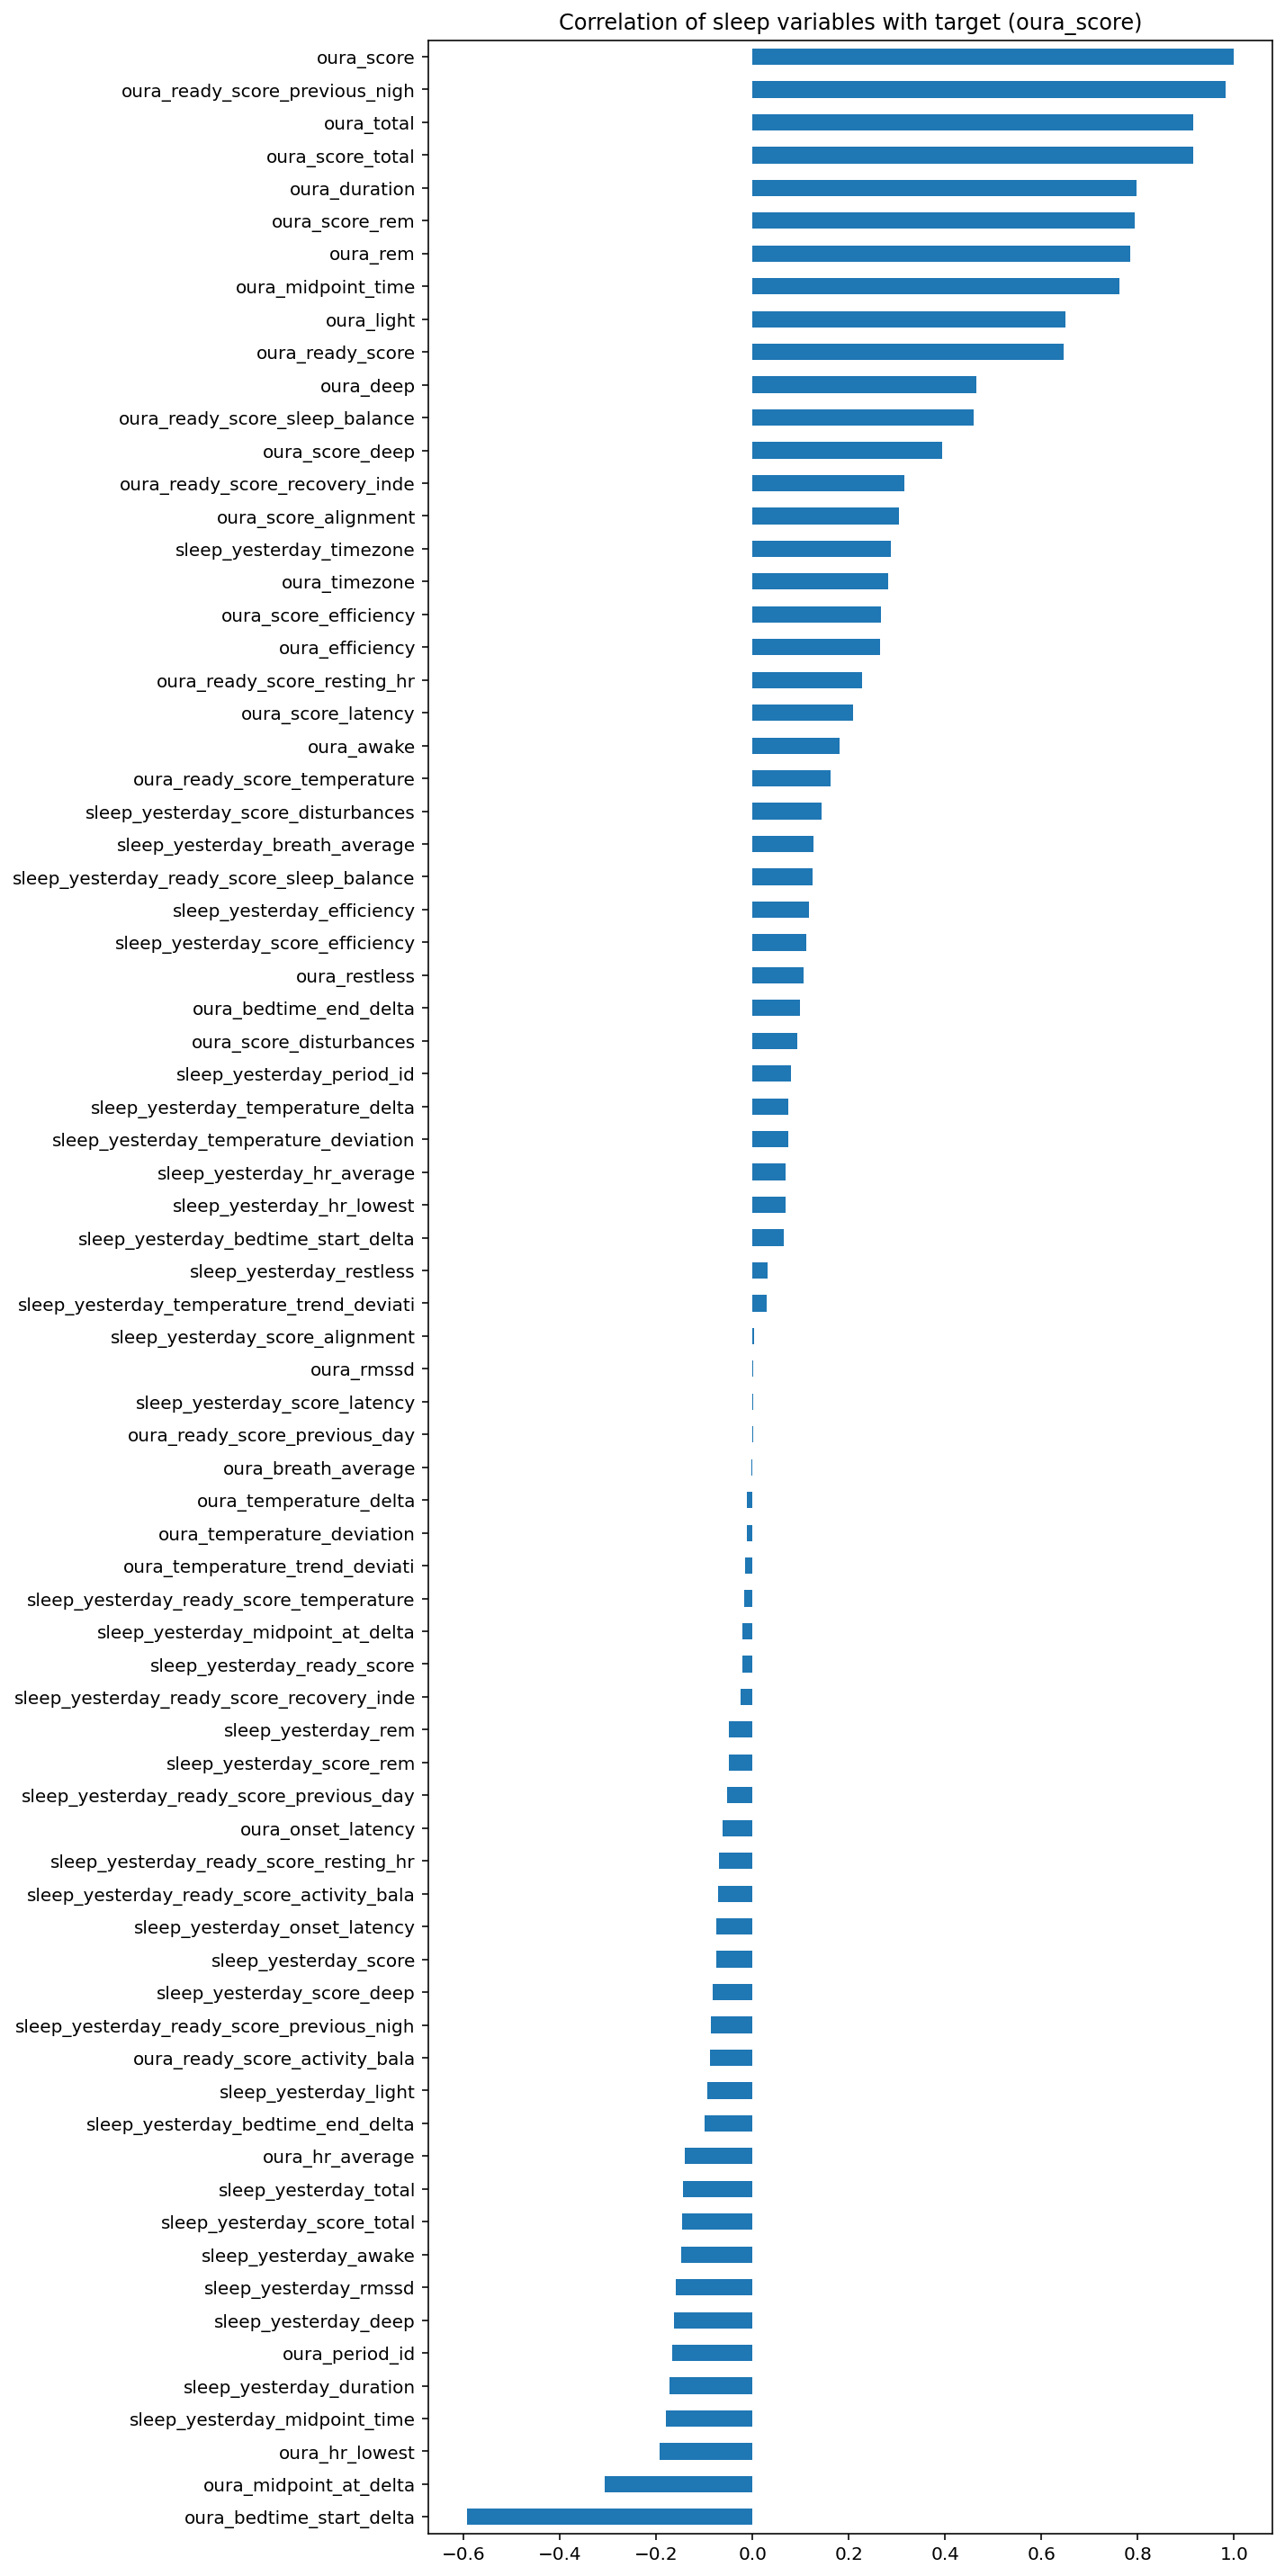

In [60]:
to_target[sleepcols].sort_values().plot(kind='barh', figsize=(10, 20))
plt.title('Correlation of sleep variables with target (oura_score)')
plt.tight_layout()
plt.savefig(FIGSDIR/'02_correlation_scores_bar_sleep.eps')
plt.show()

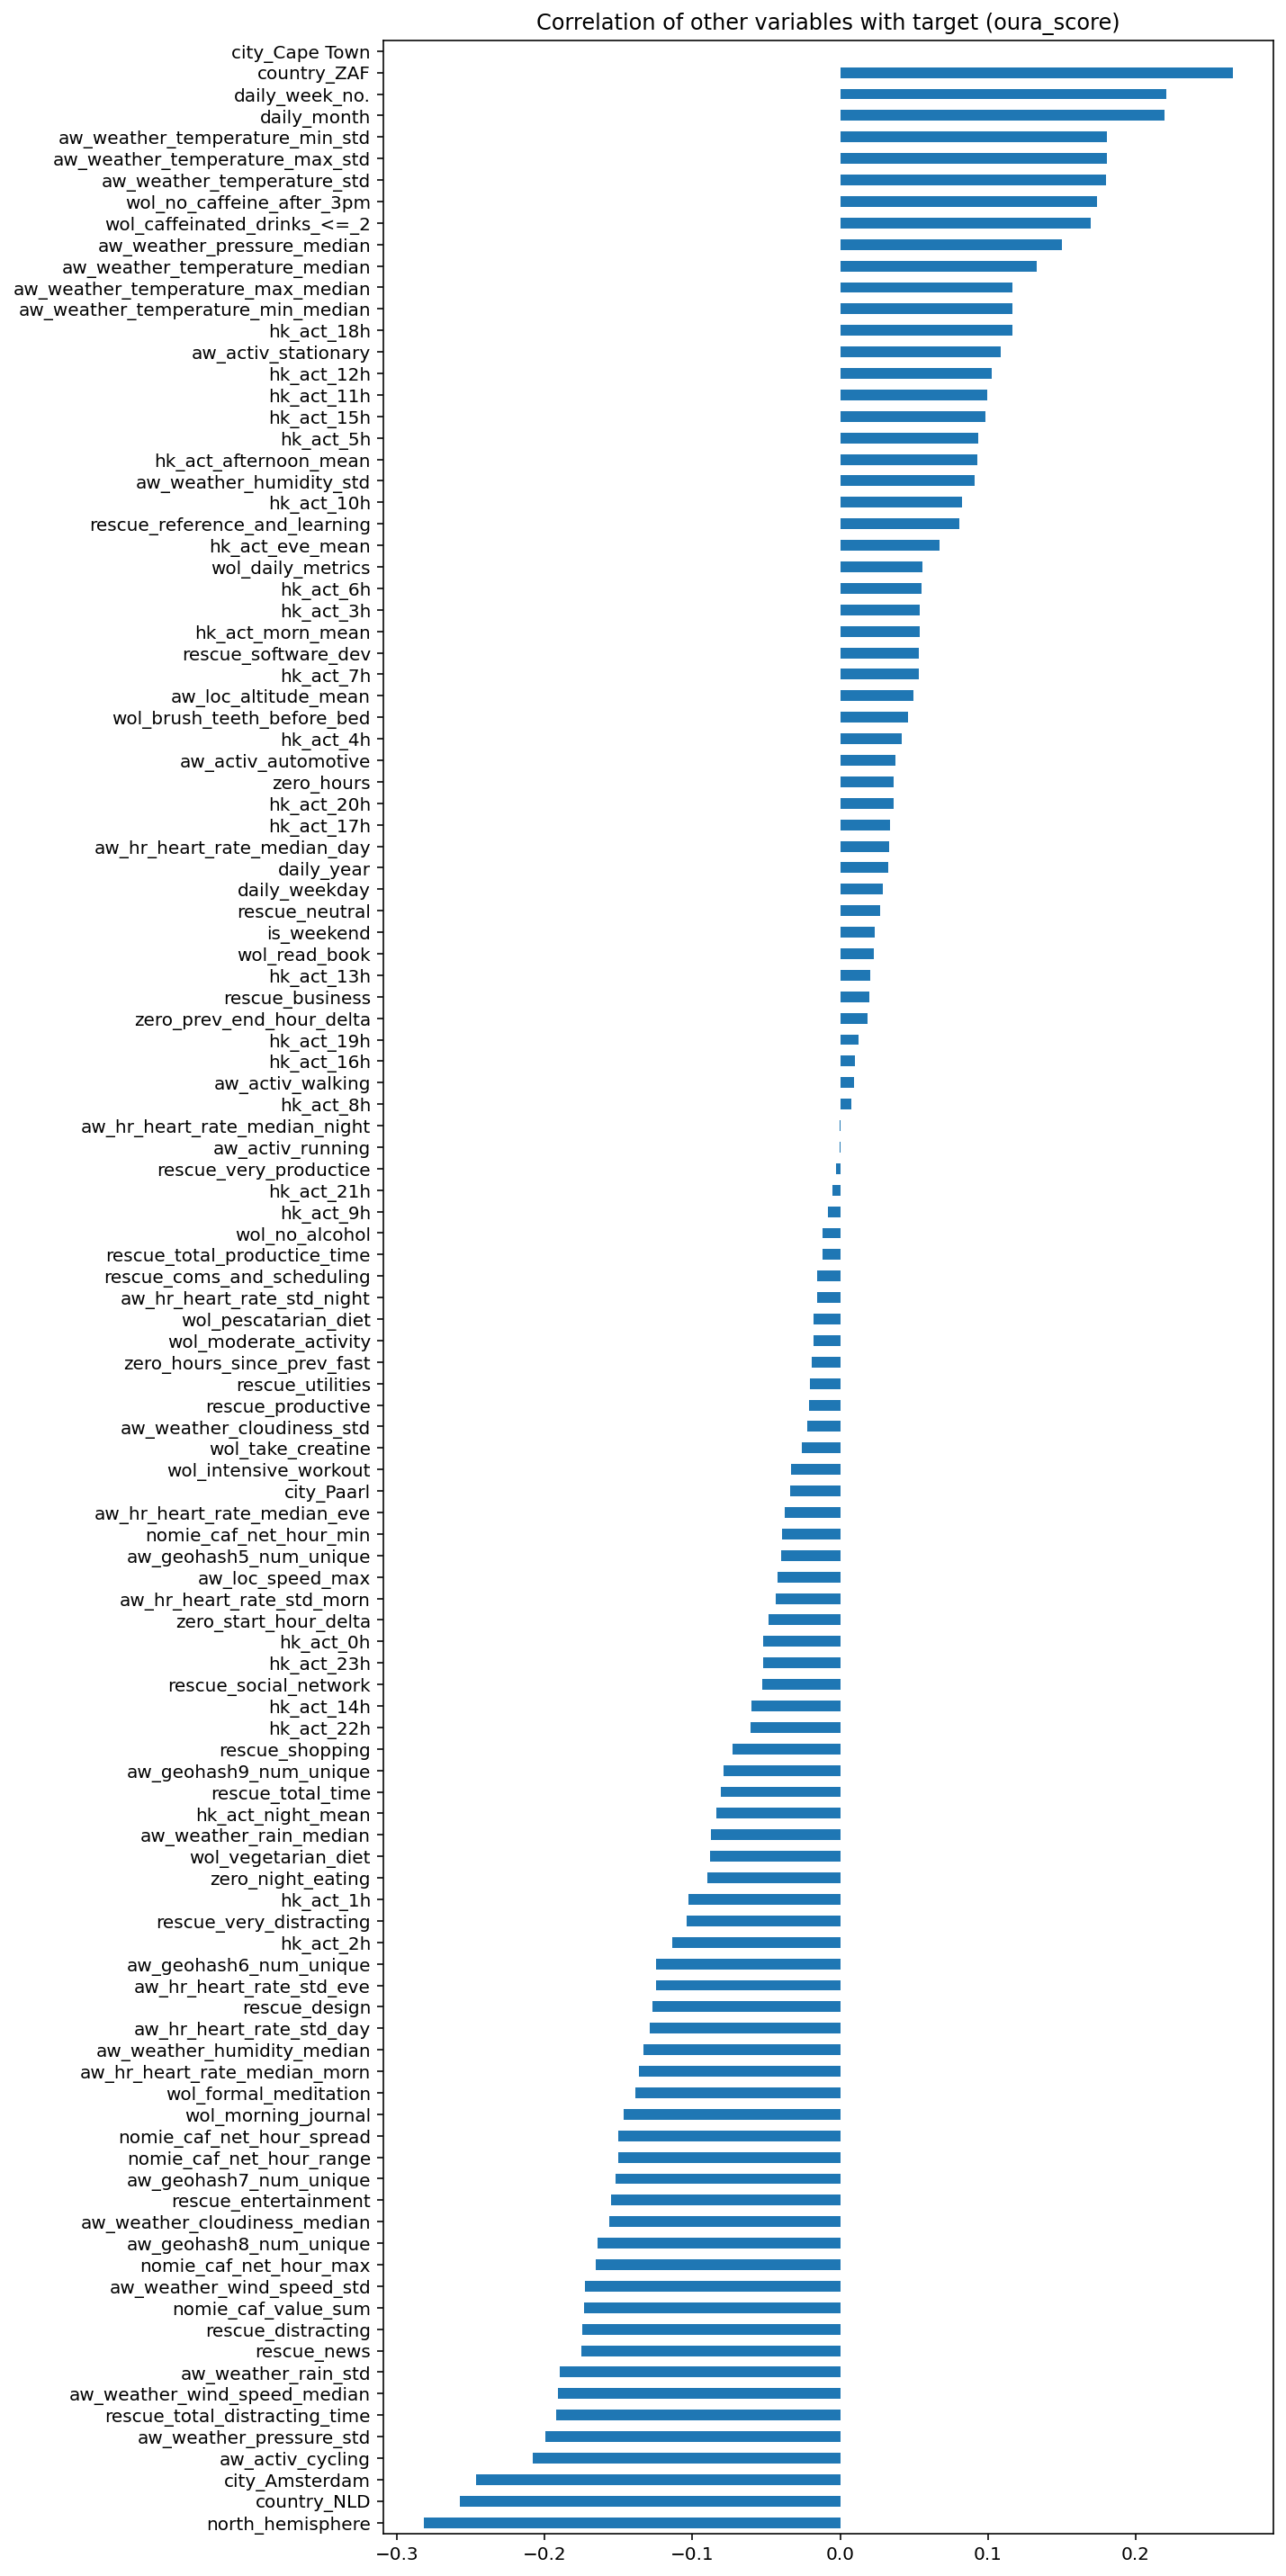

In [61]:
to_target[othercols].sort_values().plot(kind='barh', figsize=(10, 20))
plt.title('Correlation of other variables with target (oura_score)')
plt.tight_layout()
plt.savefig(FIGSDIR/'02_correlation_scores_bar_other.eps')
plt.show()

In [62]:
print(corr.shape)
_corr = corr.dropna(axis=1, thresh=100).dropna(axis=0)
print(_corr.shape)
_corr = 1-np.abs(_corr)

(207, 207)
(198, 204)


In [64]:
# https://stackoverflow.com/questions/38070478/how-to-do-clustering-using-the-matrix-of-correlation-coefficients
from sklearn.cluster import AffinityPropagation, AgglomerativeClustering, KMeans

clustering = AffinityPropagation(random_state=42).fit(_corr)

In [65]:
clustering.cluster_centers_.shape

(29, 204)

In [66]:
clustering.labels_.shape

(198,)

In [67]:
corr_clust = pd.DataFrame({'feature': _corr.index, 'cluster': clustering.labels_})
corr_clust.shape

(198, 2)

In [68]:
corr_clust[corr_clust.cluster == 22]

feature  cluster
82                       hk_act_0h       22
83                       hk_act_1h       22
84                       hk_act_2h       22
106              hk_act_night_mean       22
133                     zero_hours       22
134              zero_night_eating       22
135          zero_start_hour_delta       22
136     zero_hours_since_prev_fast       22
187  aw_hr_heart_rate_median_night       22

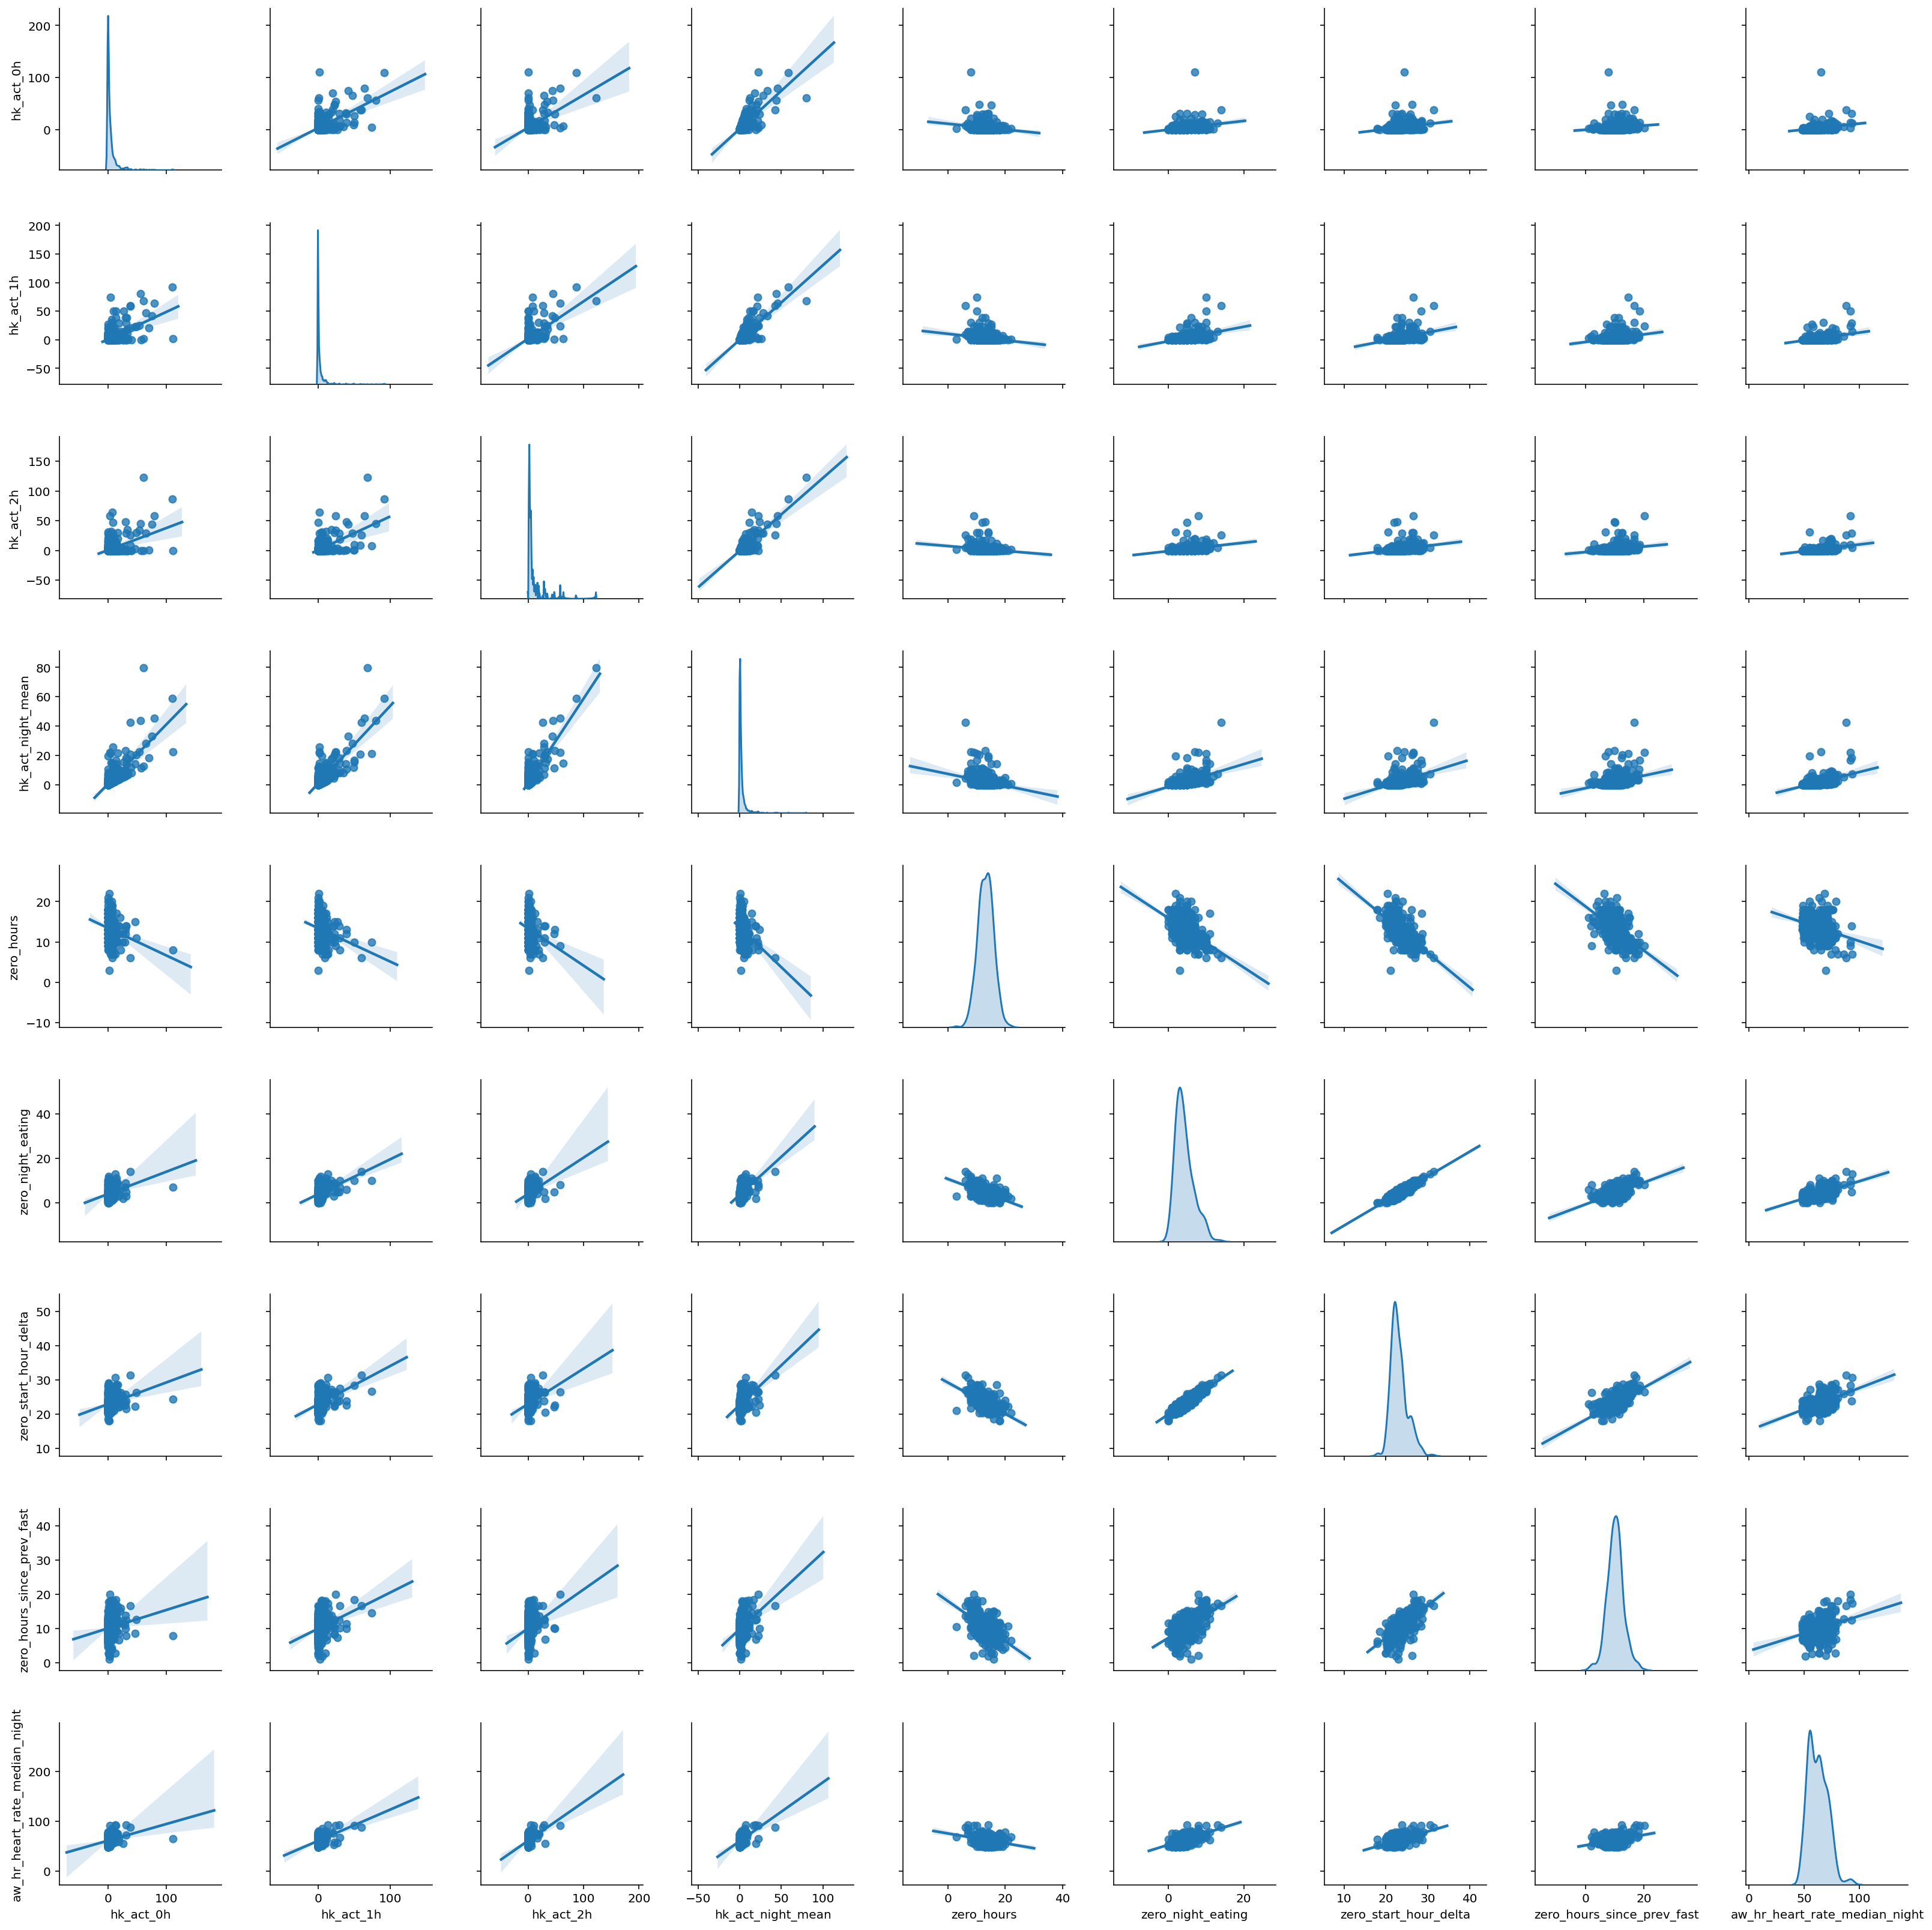

In [69]:
sns.pairplot(df_unified[corr_clust[corr_clust.cluster == 22].feature], kind='reg', diag_kind='kde')

(198, 204)
(19503,)
(197, 4)


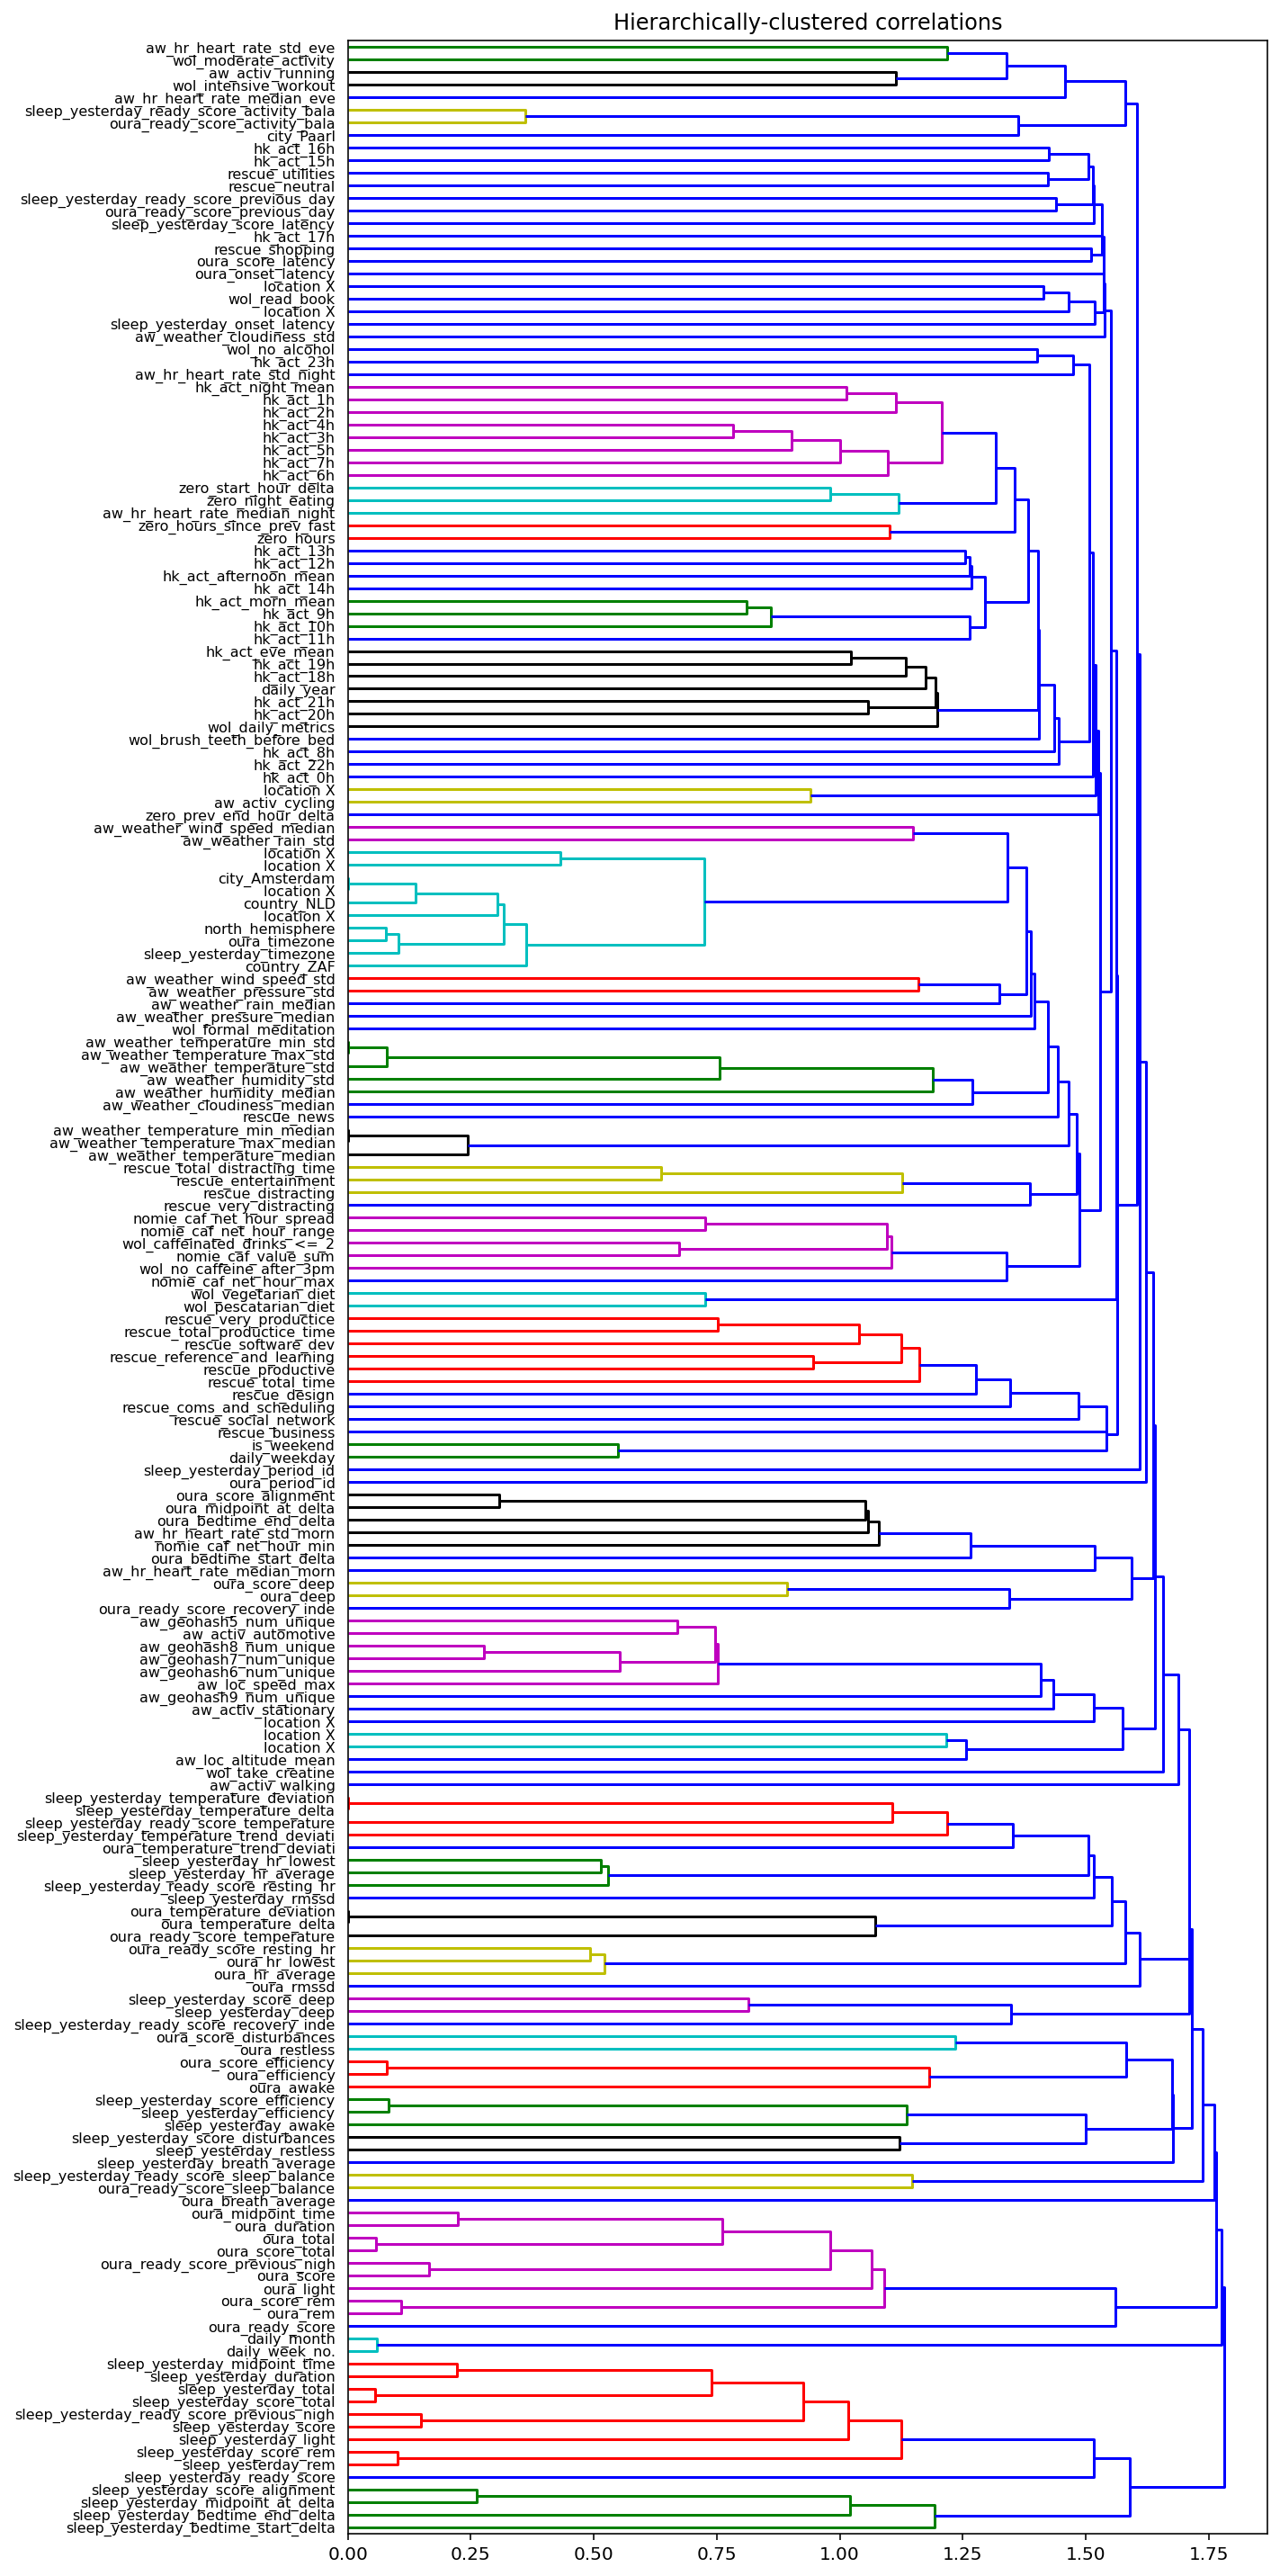

In [70]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

# Redact some for privacy reasons
ignorecols = [c for c in _corr.index if 'loc_geohash' not in c and 'location_']
redacted = [c if ('loc_geohash' not in c and 'location_' not in c) else 'location X' for c in _corr.index]

print(_corr.shape)
dists = pdist(_corr, 'euclidean')
print(dists.shape)
Z = hierarchy.linkage(dists, 'single')
print(Z.shape)
fig, ax = plt.subplots(1, 1, figsize=(10, 20))
dg = hierarchy.dendrogram(Z, ax=ax, orientation='right', labels=redacted, leaf_font_size=8)
plt.title('Hierarchically-clustered correlations')
plt.tight_layout()
plt.savefig(FIGSDIR/'02_correlation_hierarchy.eps')
plt.show()